## (General steps) Road to pipeline
* Import neccessary libraries
    * define useful functions - (no missing values)
    * read in data
<br><br>
* filter sector-wise data
* preprocess the filtered data
    * plot sector-wise visualization
    * check for missing data
    * clean outliers
    * sector-wise groupings by volume (low/mid/high)
<br><br>
* modelling
    * hyperparameters/tunings
    * cross validation
    * feature engineering
    * prediction backtesting
<br><br>
* forecasting
    * time series pipeline

# IMPORT LIBRARIES & READ DATA

## google drive mount to colab

In [ ]:
# # connect to gdrive first
# from google.colab import drive
# drive.mount('/content/gdrive')

Mounted at /content/gdrive


## importing

In [1]:
import numpy as np
import pandas as pd
import math
import random
import itertools
import time

# visualization
import seaborn as sns
sns.set_style('darkgrid')

# date libraries
import datetime
import holidays
from datetime import date, timedelta, datetime

# matplotlib libraries
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.dates import YearLocator, DateFormatter
import matplotlib.dates as mdates

# scipy library
from scipy import stats
from scipy.stats import norm

# sklearn library
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

# prophet library
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
from prophet.diagnostics import performance_metrics, cross_validation


/home/lordmax/.virtualenvs/jupyterworld/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## defining useful functions

In [2]:
# missing data
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.

    input: pandas df
    output: pandas df

    '''

    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns:
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))

# mean absolute percentage error function
def mape(actual, pred):
    '''
    Mean Absolute Percentage Error (MAPE) Function

    input: list/series for actual values and predicted values
    output: mape value
    '''

    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

## read data

In [3]:
datapath = '../relevant_stock_market_data2.csv'
# datapath = '/content/gdrive/MyDrive/Molten Trust Limited/stock market time series data/relevant_stock_market_data2.csv'

In [4]:
tsdata = pd.read_csv(datapath, parse_dates=['DATE'], index_col='DATE')

In [5]:
tsdata.head()

SYMBOL  CLOSEPRICE    SECTOR
DATE                                     
2003-01-02  ACADEMY        0.53  SERVICES
2003-01-03  ACADEMY        0.53  SERVICES
2003-01-06  ACADEMY        0.53  SERVICES
2003-01-07  ACADEMY        0.53  SERVICES
2003-01-08  ACADEMY        0.53  SERVICES

In [6]:
min(tsdata.index), max(tsdata.index)

(Timestamp('2003-01-02 00:00:00'), Timestamp('2023-02-28 00:00:00'))

# FILTER/RESTRUCTURE

In [7]:
tsdata.SECTOR.unique()

array(['SERVICES', 'FINANCIAL SERVICES', 'NATURAL RESOURCES',
       'CONSTRUCTION/REAL ESTATE', 'OIL AND GAS', 'INDUSTRIAL GOODS',
       'CONSUMER GOODS', 'CONGLOMERATES', 'HEALTHCARE', 'AGRICULTURE',
       'ICT', 'UTILITIES'], dtype=object)

In [8]:
# filtering for agriculture stocks
filtered_stock_data = tsdata[tsdata['SECTOR'] == 'FINANCIAL SERVICES']

In [9]:
del filtered_stock_data['SECTOR']

In [10]:
filtered_stock_data.head()

SYMBOL  CLOSEPRICE
DATE                              
2003-01-02  ACCESSCORP        1.82
2003-01-03  ACCESSCORP        1.83
2003-01-06  ACCESSCORP        1.90
2003-01-07  ACCESSCORP        1.90
2003-01-08  ACCESSCORP        1.98

In [11]:
filtered_stock_data.SYMBOL.unique()

array(['ACCESSCORP', 'AIICO', 'CORNERST', 'FBNH', 'GTCO', 'GUINEAINS',
       'LASACO', 'LINKASSURE', 'MBENEFIT', 'NEM', 'NESF', 'NIGERINS',
       'PRESTIGE', 'ROYALEX', 'STDINSURE', 'STERLNBANK', 'SUNUASSUR',
       'UBA', 'UBN', 'WAPIC', 'WEMABANK', 'FCMB', 'ZENITHBANK',
       'FIDELITYBK', 'STANBIC', 'UNITYBNK', 'ETI', 'SOVRENINS', 'UNHOMES',
       'DEAPCAP', 'INTENEGINS', 'STACO', 'ABBEYBDS', 'ASOSAVINGS',
       'CHIPLC', 'GOLDINSURE', 'REGALINS', 'UNIVINSURE', 'AFRINSURE',
       'MANSARD', 'RESORTSAL', 'VERITASKAP', 'NPFMCRFBK', 'AFRIPRUD',
       'INFINITY', 'UCAP', 'LIVINGTRUST', 'JAIZBANK', 'NGXGROUP'],
      dtype=object)

In [12]:
# pivoting the Dataframe to the number of unique symbols
final_tsdata = filtered_stock_data.pivot(columns='SYMBOL', values='CLOSEPRICE')
# final_tsdata = pivoted_tsdata.rename(columns={'ELLAHLAKES': 'ELLAHLAKES', 'LIVESTOCK': 'LIVESTOCK', 'OKOMUOIL': 'OKOMUOIL',
#                                               'PRESCO': 'PRESCO', 'FTNCOCOA': 'FTNCOCOA'})


In [13]:
# Resample the data with daily frequency by interpolation
financial_tsdata = final_tsdata.resample('D').interpolate(method='linear')

In [14]:
financial_tsdata.fillna(0, inplace=True)

# PREPROCESSING

## visualization

In [19]:
pd.set_option('display.max_columns', None)

In [33]:
financial_tsdata

SYMBOL      ABBEYBDS  ACCESSCORP  AFRIPRUD     AIICO   ETI       FBNH  FCMB  \
DATE                                                                          
2003-01-02      0.00    1.820000       0.0  1.370000   0.0  20.800000  0.00   
2003-01-03      0.00    1.830000       0.0  1.430000   0.0  20.800000  0.00   
2003-01-04      0.00    1.853333       0.0  1.453333   0.0  20.833333  0.00   
2003-01-05      0.00    1.876667       0.0  1.476667   0.0  20.866667  0.00   
2003-01-06      0.00    1.900000       0.0  1.500000   0.0  20.900000  0.00   
...              ...         ...       ...       ...   ...        ...   ...   
2023-02-24      1.68    9.200000       6.3  0.590000  13.0  11.600000  4.46   
2023-02-25      1.68    9.233333       6.3  0.593333  13.0  11.600000  4.46   
2023-02-26      1.68    9.266667       6.3  0.596667  13.0  11.600000  4.46   
2023-02-27      1.68    9.300000       6.3  0.600000  13.0  11.600000  4.46   
2023-02-28      1.68    9.550000       6.3  0.600000  13.0  11.650000  4.46   

SYMBOL      FIDELITYBK       GTCO  INFINITY  INTENEGINS  JAIZBANK    LASACO  \
DATE                                                                          
2003-01-02    0.000000   5.150000      0.00    0.000000  0.000000  0.900000   
2003-01-03    0.000000   5.280000      0.00    0.000000  0.000000  0.900000   
2003-01-04    0.000000   5.316667      0.00    0.000000  0.000000  0.900000   
2003-01-05    0.000000   5.353333      0.00    0.000000  0.000000  0.900000   
2003-01-06    0.000000   5.390000      0.00    0.000000  0.000000  0.900000   
...                ...        ...       ...         ...       ...       ...   
2023-02-24    5.050000  25.500000      1.27    1.190000  0.900000  1.050000   
2023-02-25    5.033333  25.666667      1.27    1.193333  0.903333  1.046667   
2023-02-26    5.016667  25.833333      1.27    1.196667  0.906667  1.043333   
2023-02-27    5.000000  26.000000      1.27    1.200000  0.910000  1.040000   
2023-02-28    5.100000  26.650000      1.27    1.190000  0.940000  1.020000   

SYMBOL      LIVINGTRUST  MANSARD  NEM   NESF  NGXGROUP  NPFMCRFBK  STANBIC  \
DATE                                                                         
2003-01-02         0.00      0.0  0.5  940.5       0.0       0.00     0.00   
2003-01-03         0.00      0.0  0.5  940.5       0.0       0.00     0.00   
2003-01-04         0.00      0.0  0.5  940.5       0.0       0.00     0.00   
2003-01-05         0.00      0.0  0.5  940.5       0.0       0.00     0.00   
2003-01-06         0.00      0.0  0.5  940.5       0.0       0.00     0.00   
...                 ...      ...  ...    ...       ...        ...      ...   
2023-02-24         2.70      2.0  4.1  552.2      27.0       1.80    34.50   
2023-02-25         2.73      2.0  4.1  552.2      27.0       1.80    35.65   
2023-02-26         2.76      2.0  4.1  552.2      27.0       1.80    36.80   
2023-02-27         2.79      2.0  4.1  552.2      27.0       1.80    37.95   
2023-02-28         2.79      2.0  4.1  552.2      29.0       1.89    41.70   

SYMBOL      STERLNBANK       UBA        UBN   UCAP  UNHOMES  WEMABANK  \
DATE                                                                    
2003-01-02    3.700000  5.790000  22.390000   0.00     0.00      5.76   
2003-01-03    3.700000  5.830000  22.300000   0.00     0.00      5.76   
2003-01-04    3.700000  5.833333  22.533333   0.00     0.00      5.76   
2003-01-05    3.700000  5.836667  22.766667   0.00     0.00      5.76   
2003-01-06    3.700000  5.840000  23.000000   0.00     0.00      5.76   
...                ...       ...        ...    ...      ...       ...   
2023-02-24    1.510000  8.500000   6.600000  15.45     3.02      4.00   
2023-02-25    1.526667  8.500000   6.600000  15.30     3.02      4.00   
2023-02-26    1.543333  8.500000   6.600000  15.15     3.02      4.00   
2023-02-27    1.560000  8.500000   6.600000  15.00     3.02      4.00   
2023-02-28    1.520000  8.700000   6.600000  15.35   

remove AFRINSURE, ASOSAVINGS, CHIPLC, CORNERST, DEAPCAP, GOLDINSURE, GUINEAINS, LINKASSURE, MBENEFIT, NIGERINS, PRESTIGE, REGALINS, RESORTSAL, ROYALEX, SOVRENINS, STACO, STDINSURE, SUNUASSUR, UNITYBNK, UNIVINSURE, VERITASKAP, WAPIC

In [32]:
del financial_tsdata['AFRINSURE']
del financial_tsdata['ASOSAVINGS']
del financial_tsdata['CHIPLC']
del financial_tsdata['CORNERST']
del financial_tsdata['DEAPCAP']
del financial_tsdata['GOLDINSURE']
del financial_tsdata['GUINEAINS']
del financial_tsdata['LINKASSURE']
del financial_tsdata['MBENEFIT']
del financial_tsdata['NIGERINS']
del financial_tsdata['PRESTIGE']
del financial_tsdata['REGALINS']
del financial_tsdata['RESORTSAL']
del financial_tsdata['ROYALEX']
del financial_tsdata['SOVRENINS']
del financial_tsdata['STACO']
del financial_tsdata['STDINSURE']
del financial_tsdata['SUNUASSUR']
del financial_tsdata['UNITYBNK']
del financial_tsdata['UNIVINSURE']
del financial_tsdata['VERITASKAP']
del financial_tsdata['WAPIC']


# financial_tsdata.columns

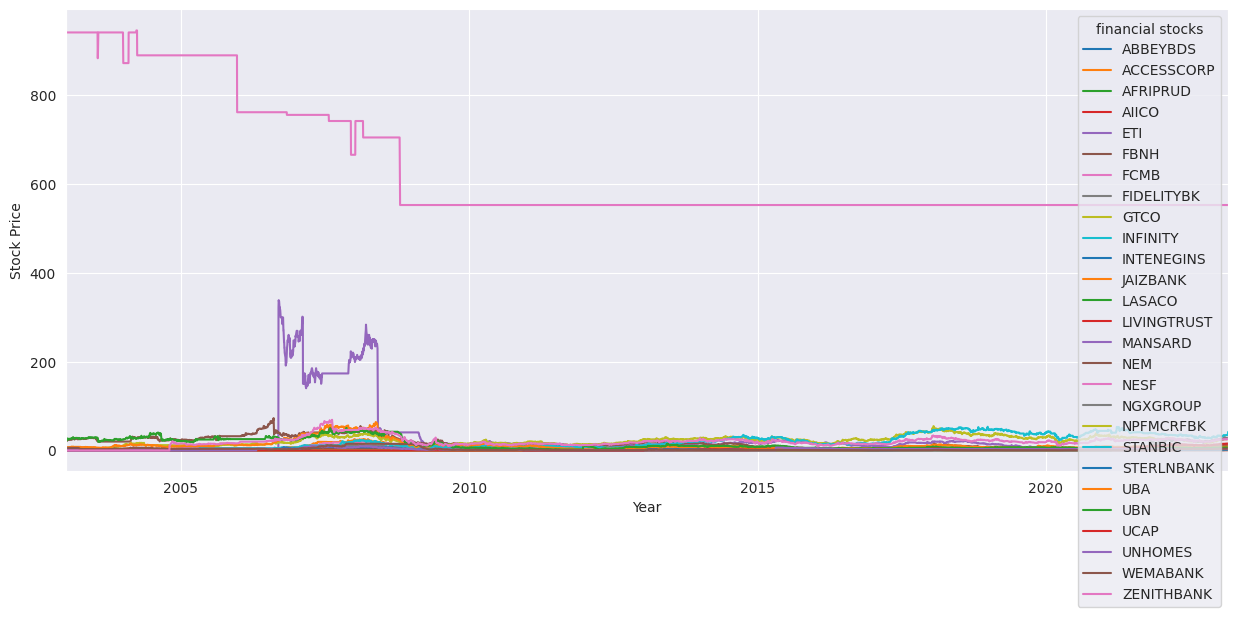

In [34]:
# Plotting
financial_tsdata.plot(figsize=(15, 6))
plt.xlabel('Year')
plt.ylabel('Stock Price')
plt.grid(True)
plt.legend(title='financial stocks', loc='upper right')
plt.show()

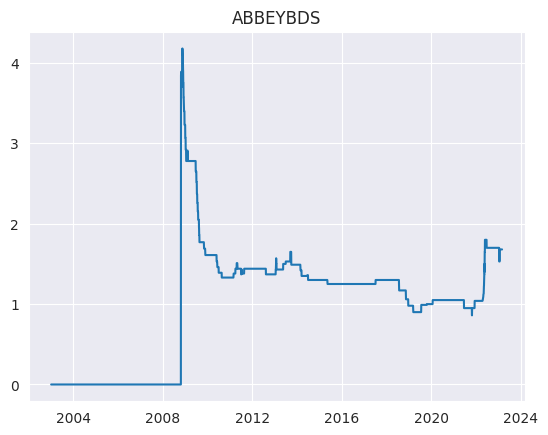

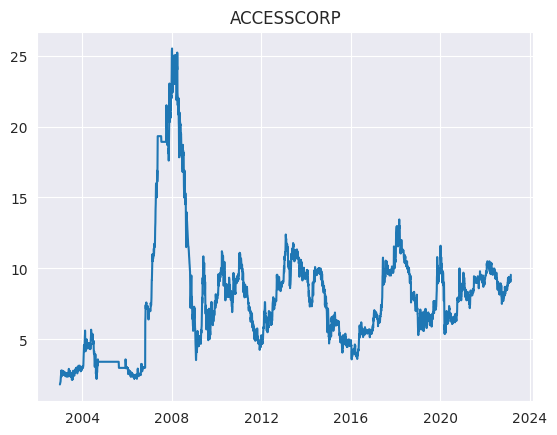

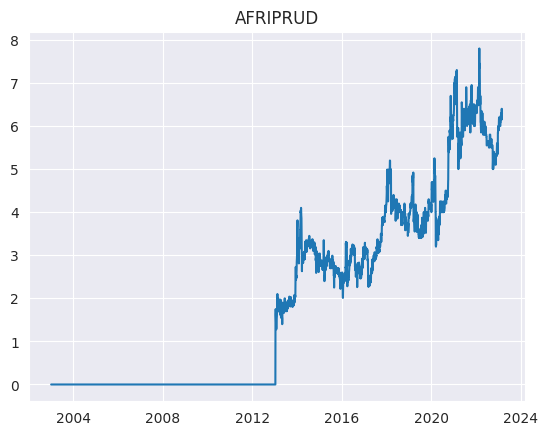

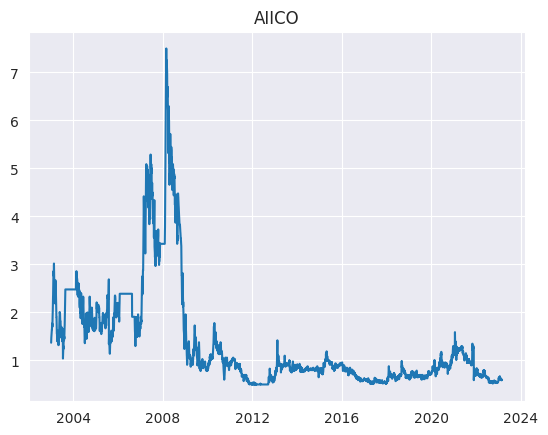

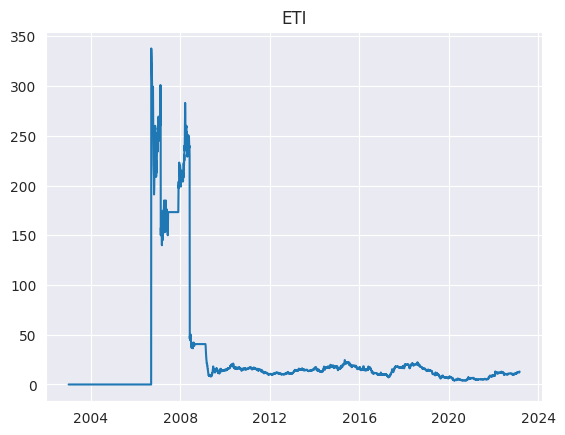

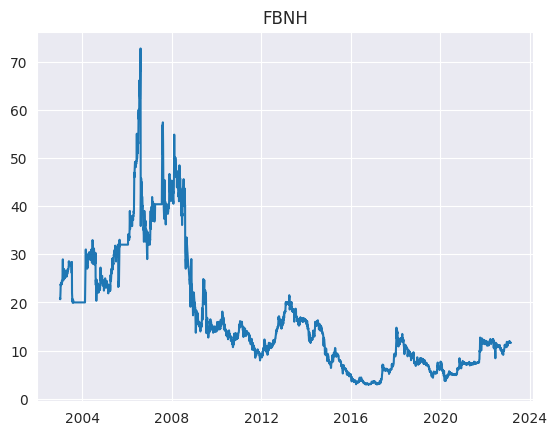

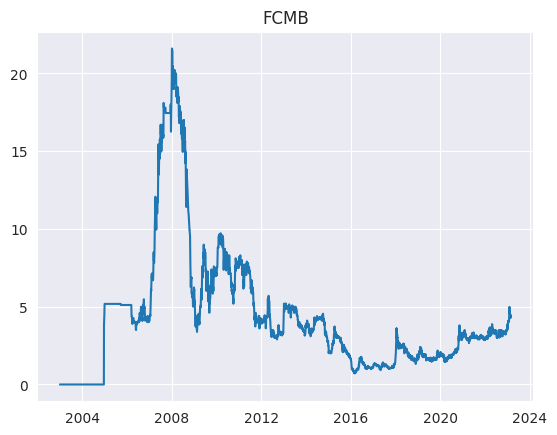

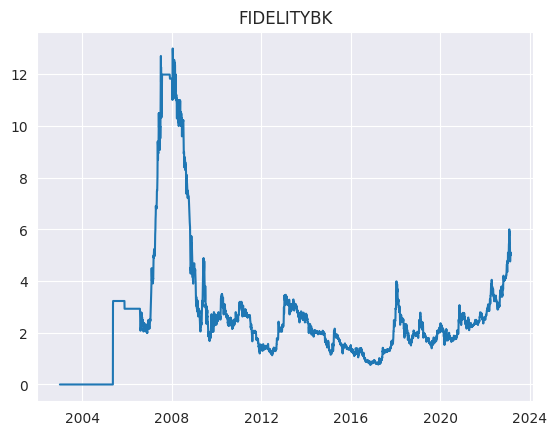

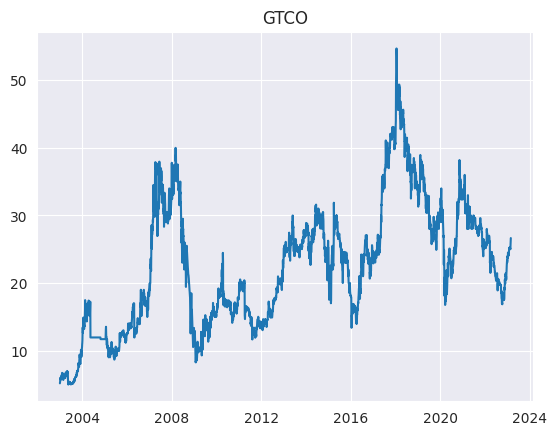

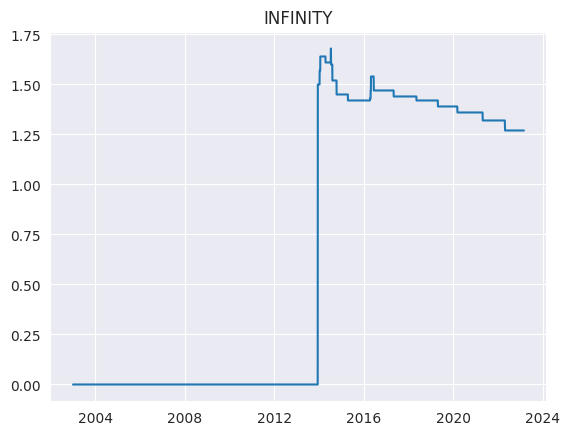

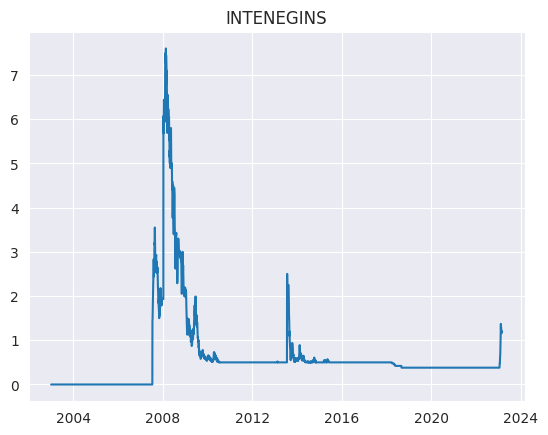

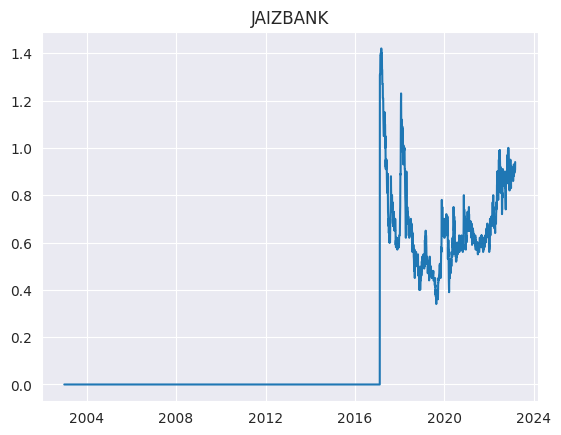

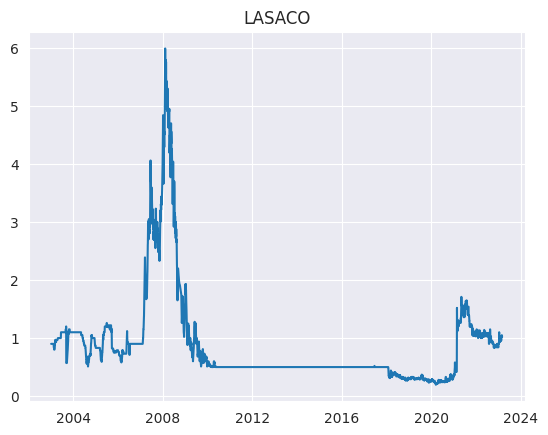

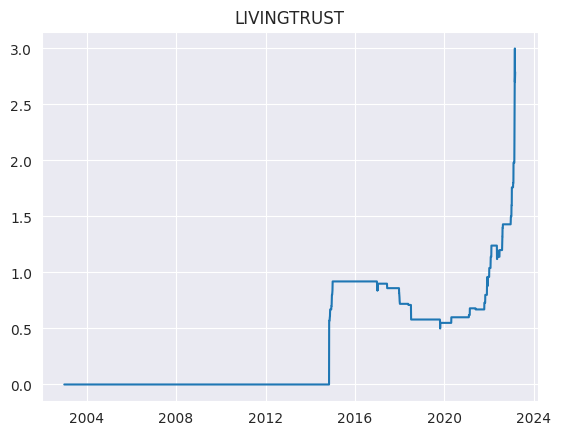

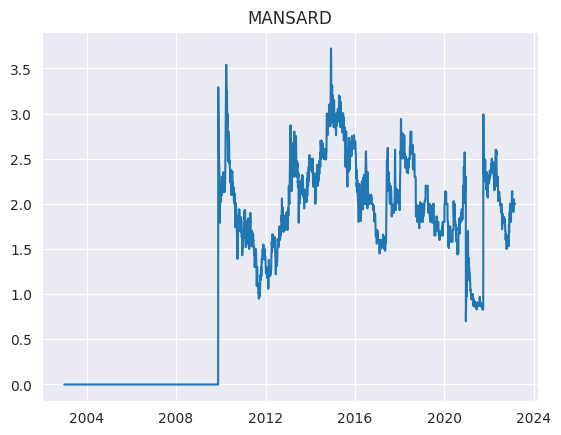

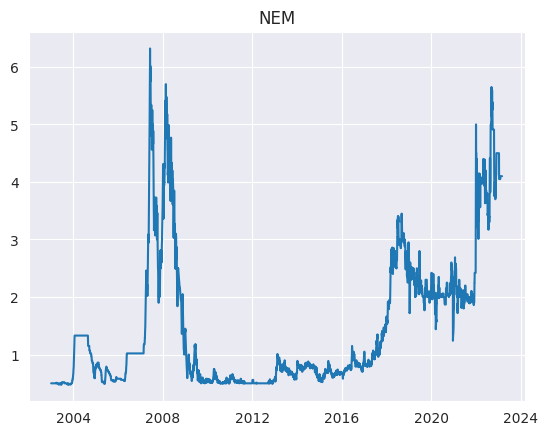

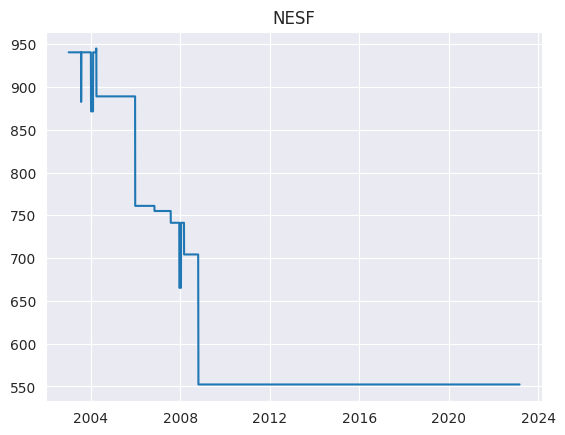

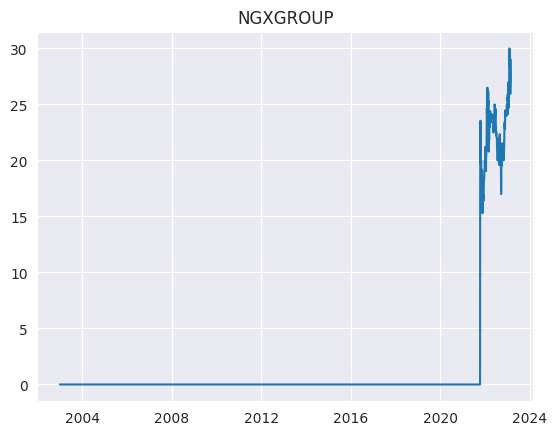

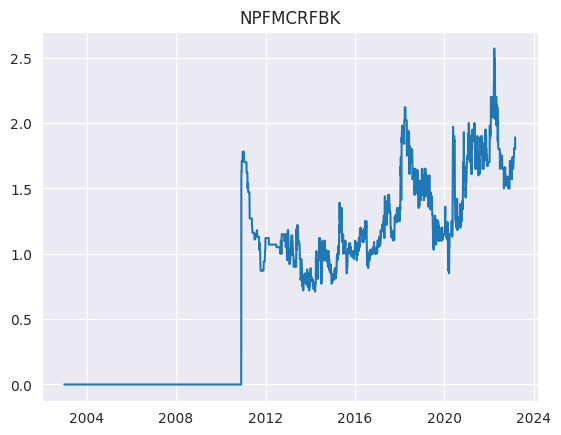

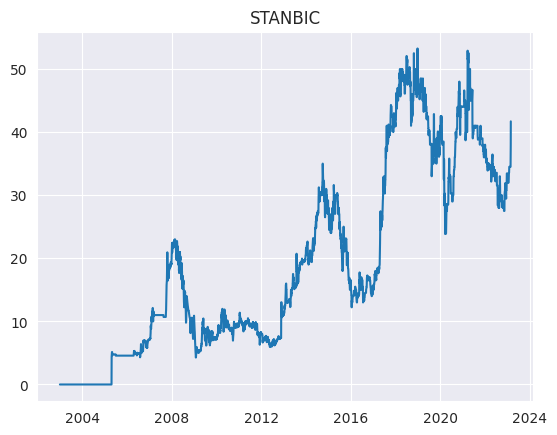

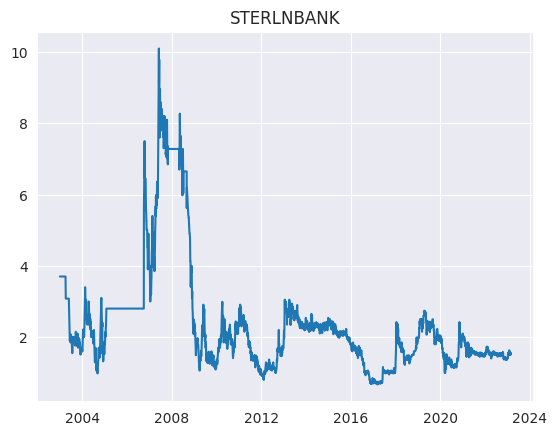

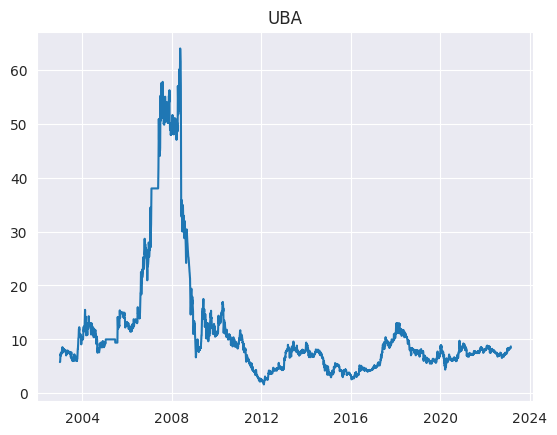

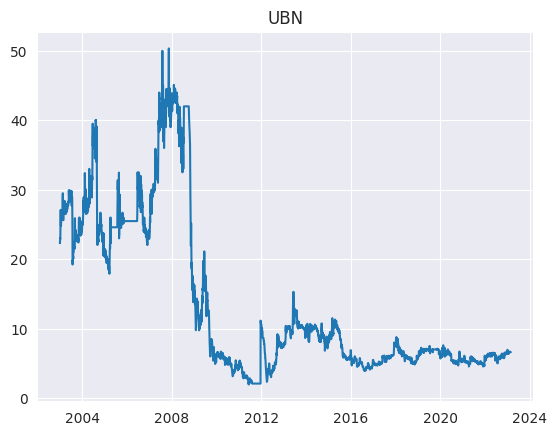

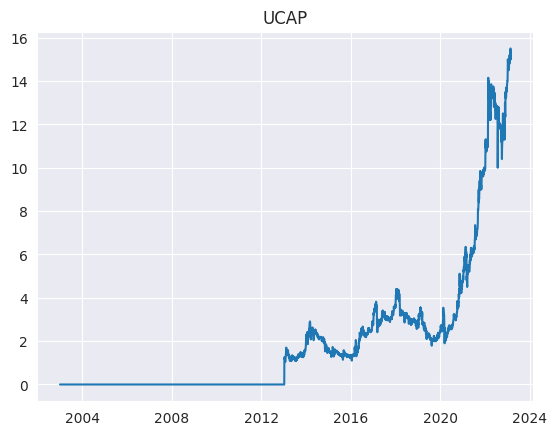

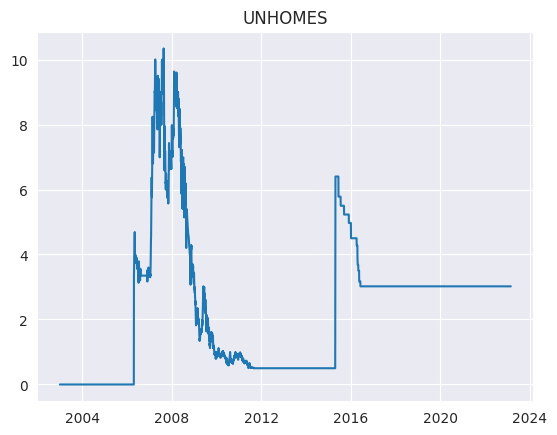

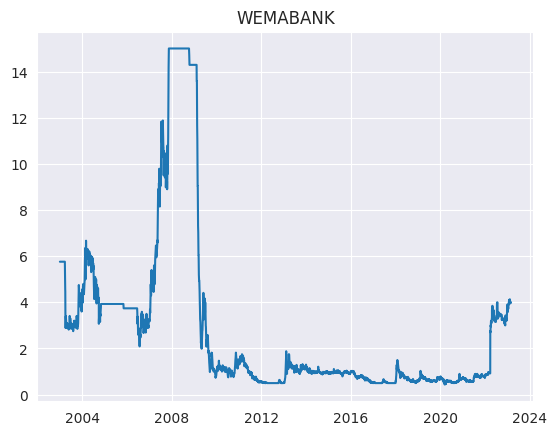

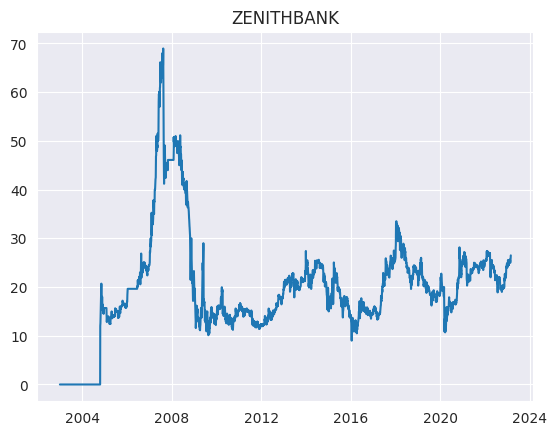

In [35]:
for column in financial_tsdata.columns:
    plt.plot(financial_tsdata[column])
    plt.title(column)
    plt.show()

## cleaning

In [36]:
missing_data(financial_tsdata)

Total  Percent    Types
SYMBOL                              
ABBEYBDS         0      0.0  float64
ACCESSCORP       0      0.0  float64
AFRIPRUD         0      0.0  float64
AIICO            0      0.0  float64
ETI              0      0.0  float64
FBNH             0      0.0  float64
FCMB             0      0.0  float64
FIDELITYBK       0      0.0  float64
GTCO             0      0.0  float64
INFINITY         0      0.0  float64
INTENEGINS       0      0.0  float64
JAIZBANK         0      0.0  float64
LASACO           0      0.0  float64
LIVINGTRUST      0      0.0  float64
MANSARD          0      0.0  float64
NEM              0      0.0  float64
NESF             0      0.0  float64
NGXGROUP         0      0.0  float64
NPFMCRFBK        0      0.0  float64
STANBIC          0      0.0  float64
STERLNBANK       0      0.0  float64
UBA              0      0.0  float64
UBN              0      0.0  float64
UCAP             0      0.0  float64
UNHOMES          0      0.0  float64
WEMABANK         0      0.0  float64
ZENITHBANK       0      0.0  float64

## outliers

<b>`Data Cleaning Requirements`</b>
* remove outliers (automated by calculating and removing <b>`z-score`</b>, while Prophet helps impute those values). This will remove the outliers near 0 for all categories.

In [37]:
# getting percentage of rows for each sector that is at 0

(financial_tsdata == 0).astype(int).sum(axis=0)/len(financial_tsdata.sum(axis=0))

SYMBOL
ABBEYBDS        78.481481
ACCESSCORP       0.000000
AFRIPRUD       135.629630
AIICO            0.000000
ETI             49.925926
FBNH             0.000000
FCMB            26.629630
FIDELITYBK      32.074074
GTCO             0.000000
INFINITY       148.000000
INTENEGINS      61.222222
JAIZBANK       190.814815
LASACO           0.000000
LIVINGTRUST    160.148148
MANSARD         93.074074
NEM              0.000000
NESF             0.000000
NGXGROUP       254.111111
NPFMCRFBK      107.037037
STANBIC         31.259259
STERLNBANK       0.000000
UBA              0.000000
UBN              0.000000
UCAP           135.629630
UNHOMES         44.740741
WEMABANK         0.000000
ZENITHBANK      24.370370
dtype: float64

<img src='../img/download.png' width=500px height=600px>

In [38]:
# breaking out each financial stocks into it's own dataframe
prediction_df_financial_list = []

# cleaning up dataframe using z-score to remove outliers that heavily bias the model
for column in financial_tsdata.columns:
    df_financial_clean = financial_tsdata[[column]].reset_index()

    z = np.abs(stats.zscore(df_financial_clean[column]))
    outlier_index = np.where(z > 2.7)[0] # As 99.7% of the data points lie between 3 standard deviations (Gaussian Distribution)a
    print("Dropping "+str(len(outlier_index))+" rows for following category: "+column)
    df_financial_clean.drop(index=outlier_index,inplace=True)
    df_financial_clean.set_index('DATE', inplace=True)
    prediction_df_financial_list.append(df_financial_clean)

Dropping 77 rows for following category: ABBEYBDS
Dropping 277 rows for following category: ACCESSCORP
Dropping 0 rows for following category: AFRIPRUD
Dropping 264 rows for following category: AIICO
Dropping 345 rows for following category: ETI
Dropping 115 rows for following category: FBNH
Dropping 400 rows for following category: FCMB
Dropping 408 rows for following category: FIDELITYBK
Dropping 51 rows for following category: GTCO
Dropping 0 rows for following category: INFINITY
Dropping 203 rows for following category: INTENEGINS
Dropping 86 rows for following category: JAIZBANK
Dropping 271 rows for following category: LASACO
Dropping 62 rows for following category: LIVINGTRUST
Dropping 0 rows for following category: MANSARD
Dropping 172 rows for following category: NEM
Dropping 0 rows for following category: NESF
Dropping 488 rows for following category: NGXGROUP
Dropping 0 rows for following category: NPFMCRFBK
Dropping 0 rows for following category: STANBIC
Dropping 408 rows f

In [40]:
[prediction_df_financial_list]

[[SYMBOL      ABBEYBDS
  DATE                
  2003-01-02      0.00
  2003-01-03      0.00
  2003-01-04      0.00
  2003-01-05      0.00
  2003-01-06      0.00
  ...              ...
  2023-02-24      1.68
  2023-02-25      1.68
  2023-02-26      1.68
  2023-02-27      1.68
  2023-02-28      1.68
  
  [7286 rows x 1 columns],
  SYMBOL      ACCESSCORP
  DATE                  
  2003-01-02    1.820000
  2003-01-03    1.830000
  2003-01-04    1.853333
  2003-01-05    1.876667
  2003-01-06    1.900000
  ...                ...
  2023-02-24    9.200000
  2023-02-25    9.233333
  2023-02-26    9.266667
  2023-02-27    9.300000
  2023-02-28    9.550000
  
  [7086 rows x 1 columns],
  SYMBOL      AFRIPRUD
  DATE                
  2003-01-02       0.0
  2003-01-03       0.0
  2003-01-04       0.0
  2003-01-05       0.0
  2003-01-06       0.0
  ...              ...
  2023-02-24       6.3
  2023-02-25       6.3
  2023-02-26       6.3
  2023-02-27       6.3
  2023-02-28       6.3
  
  [7363 rows x

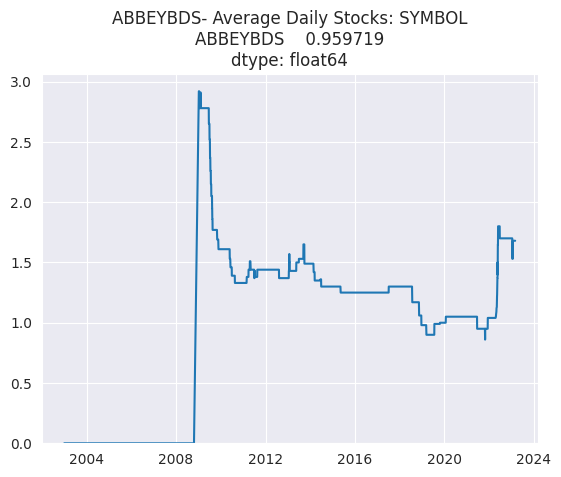

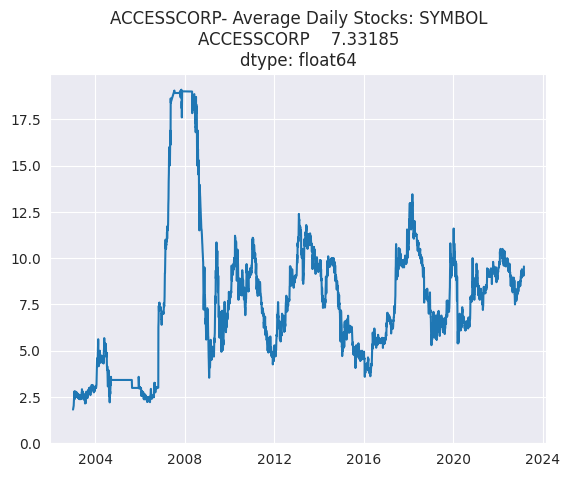

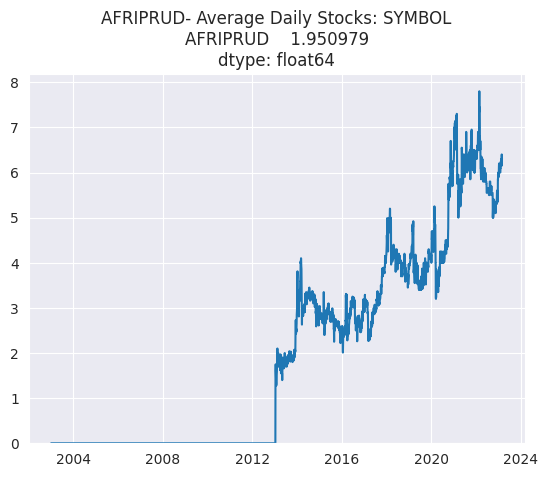

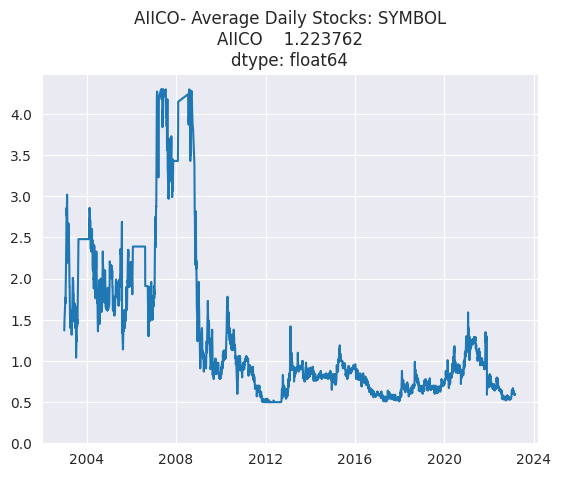

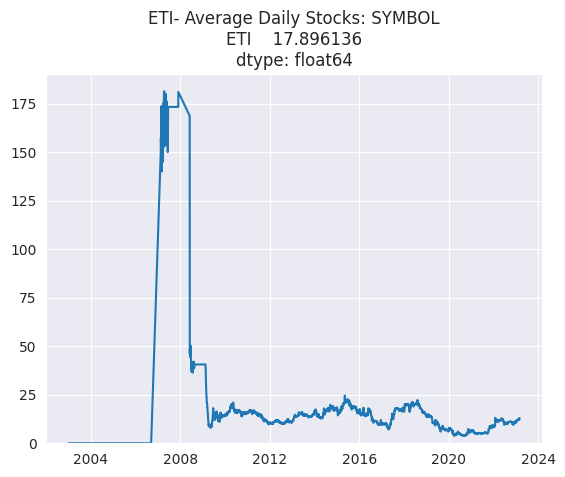

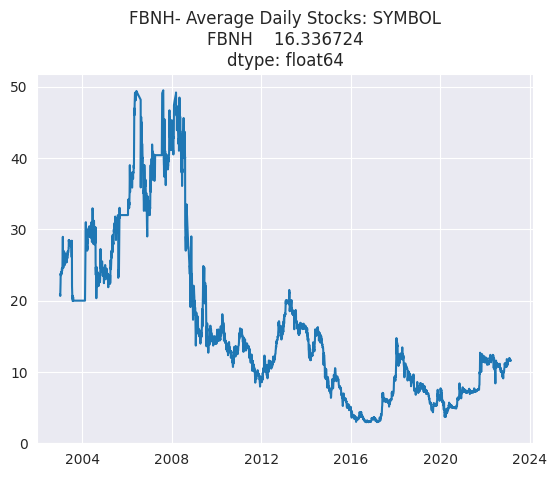

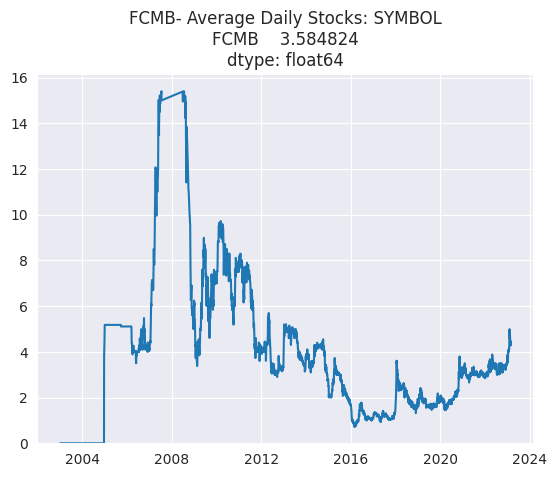

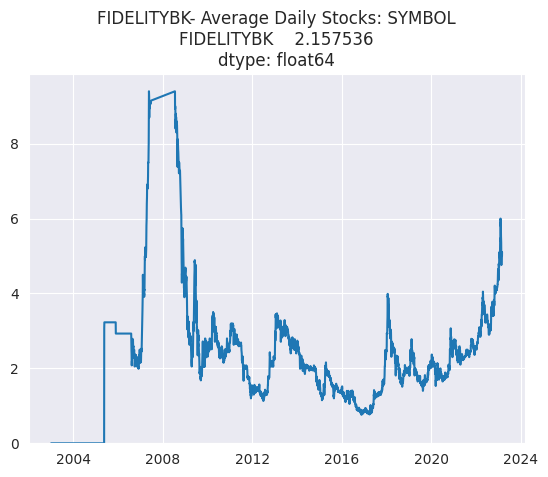

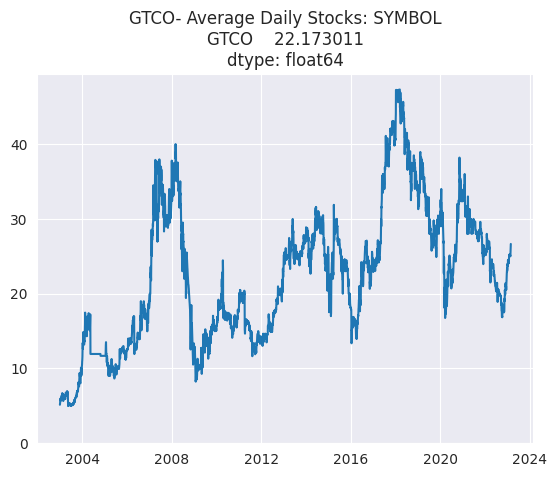

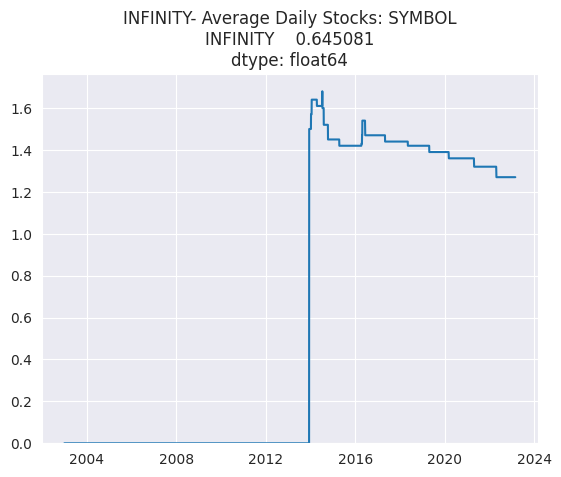

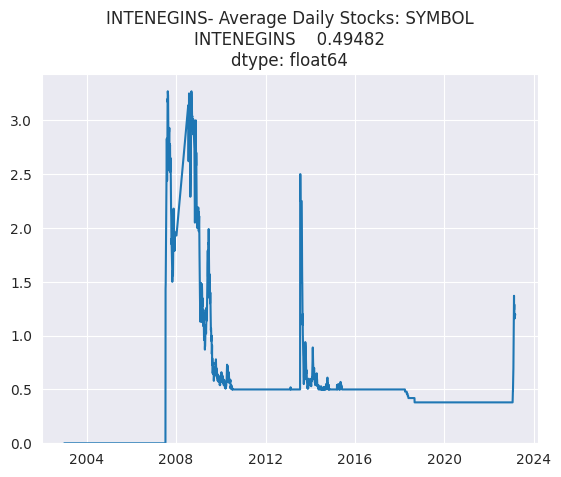

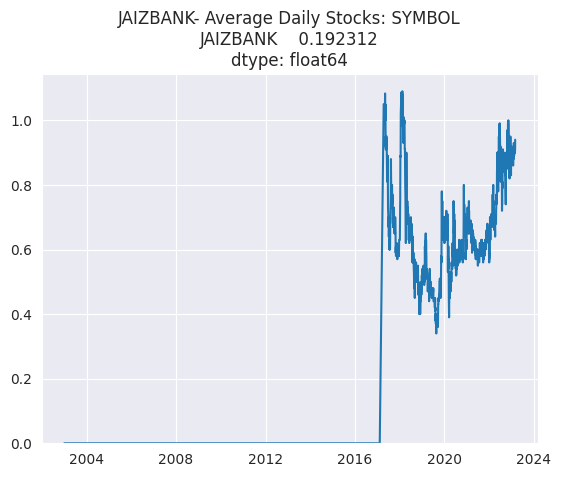

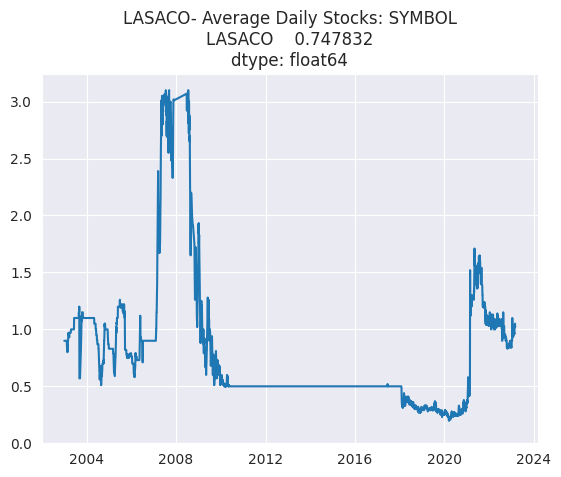

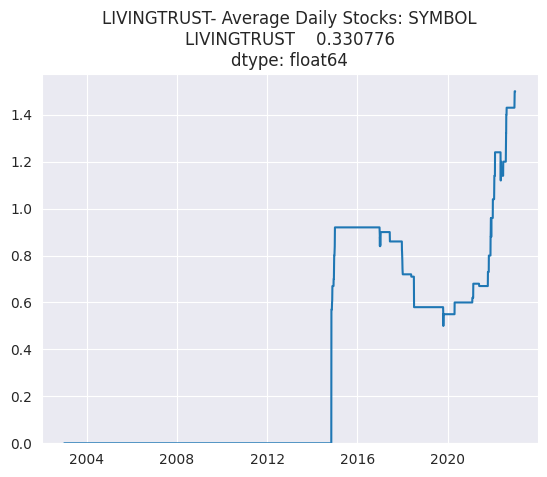

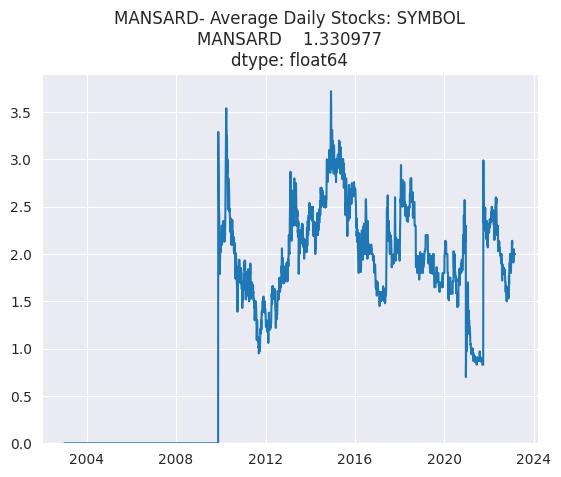

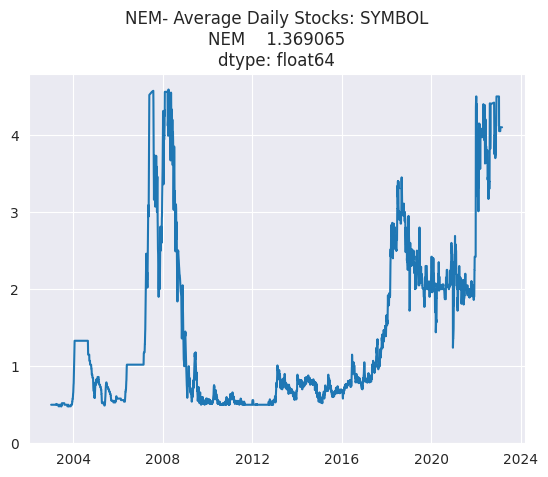

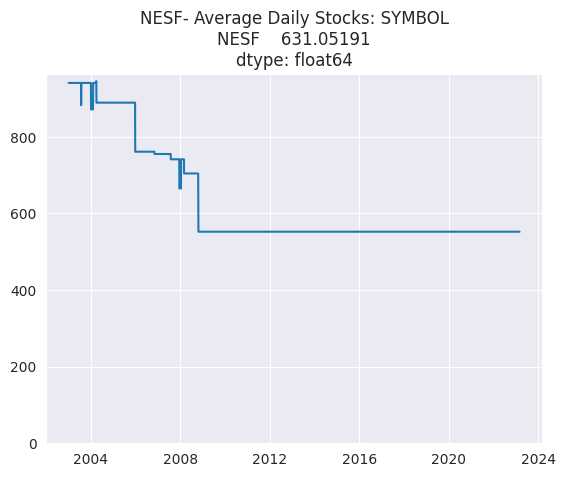

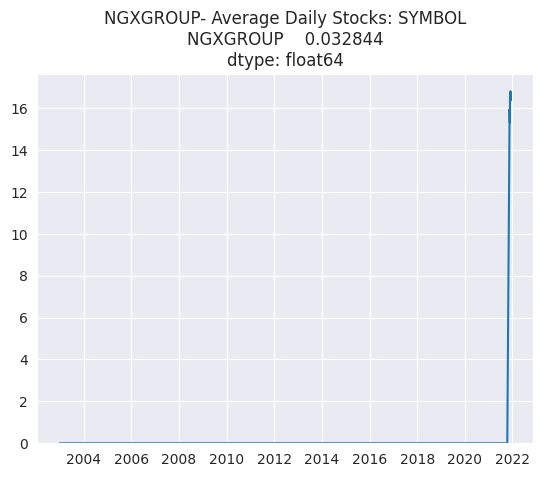

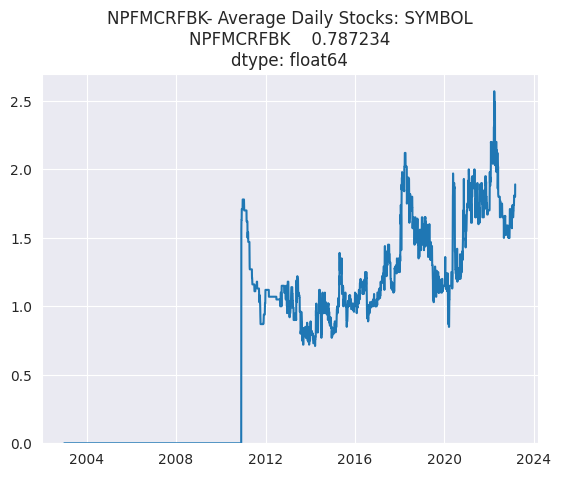

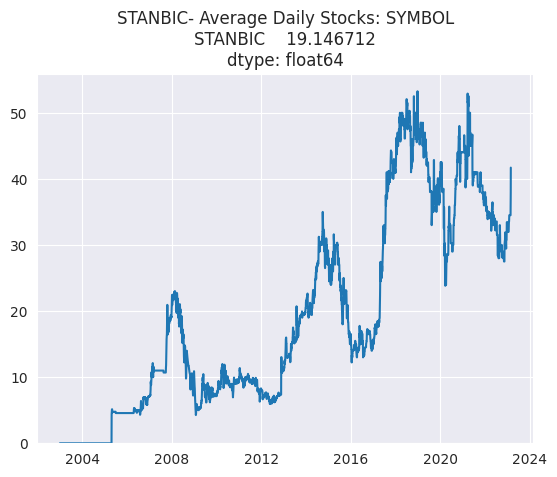

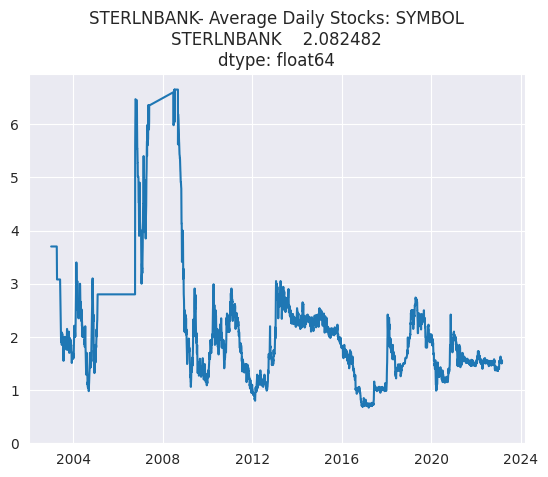

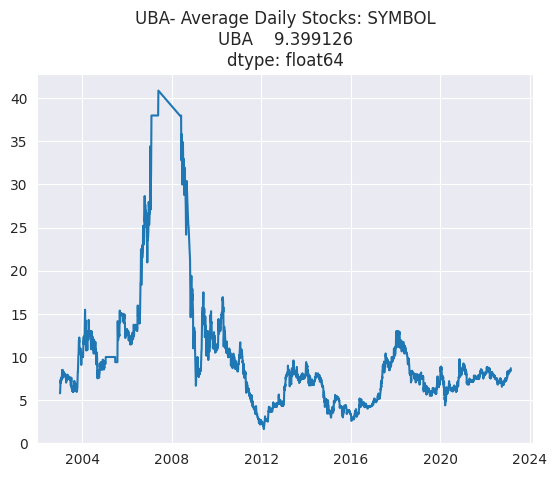

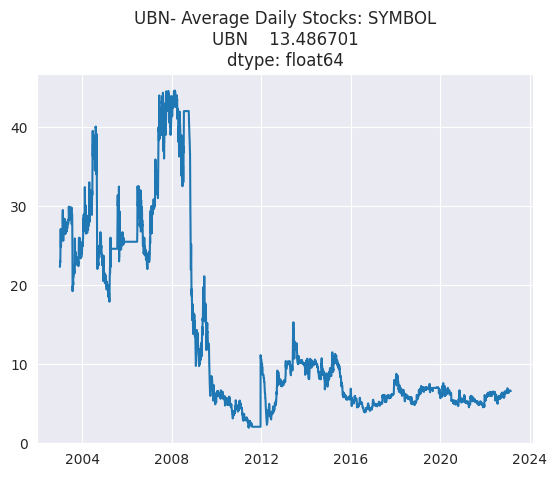

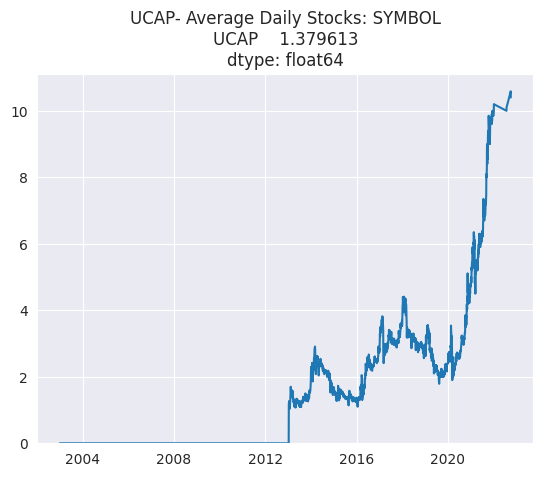

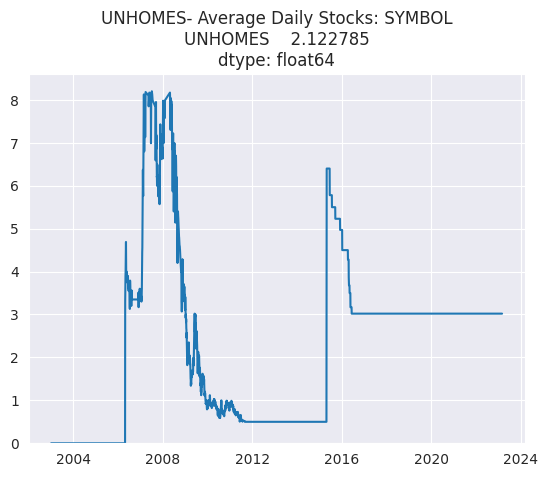

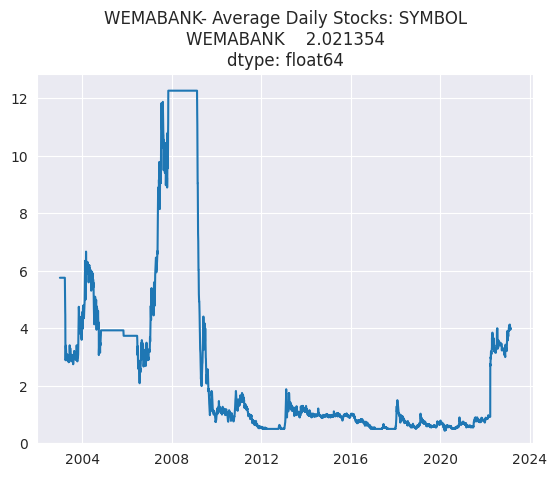

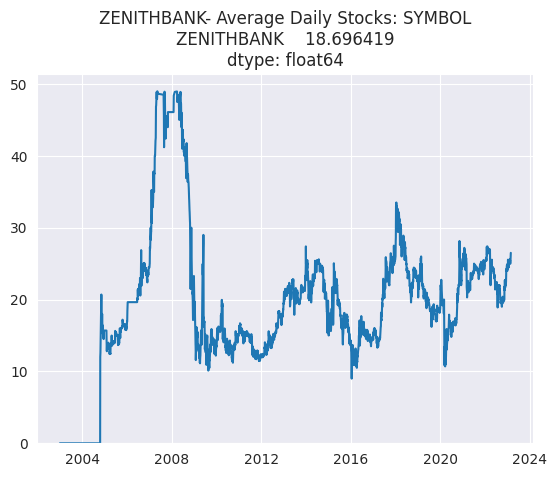

In [42]:
for i in range(len(prediction_df_financial_list)):
    plt.plot(prediction_df_financial_list[i])
    plt.title(prediction_df_financial_list[i].columns[0]+'- Average Daily Stocks: '+str(prediction_df_financial_list[i].mean()))
    plt.ylim(ymin=0)
    plt.show()

## sector-wise groupings (low/mid/high)

In [43]:
average_closeprices = financial_tsdata.apply(np.mean, axis=0).sort_values()
low, mid = np.percentile(financial_tsdata.apply(np.mean, axis=0).sort_values(), [25, 75])

In [44]:
low_vol_cols = list(average_closeprices[average_closeprices <= low].index)
mid_vol_cols = list(average_closeprices[(average_closeprices > low) & (average_closeprices < mid)].index)
high_vol_cols = list(average_closeprices[average_closeprices >= mid].index)

In [45]:
print(f'Low volume stocks are: {low_vol_cols}')
print(f'Middle volume stocks are: {mid_vol_cols}')
print(f'High volume stocks are: {high_vol_cols}')

Low volume stocks are: ['JAIZBANK', 'LIVINGTRUST', 'INTENEGINS', 'INFINITY', 'NPFMCRFBK', 'LASACO', 'ABBEYBDS']
Middle volume stocks are: ['MANSARD', 'AIICO', 'NEM', 'NGXGROUP', 'AFRIPRUD', 'UCAP', 'UNHOMES', 'STERLNBANK', 'FIDELITYBK', 'WEMABANK', 'FCMB', 'ACCESSCORP', 'UBA']
High volume stocks are: ['UBN', 'FBNH', 'STANBIC', 'ZENITHBANK', 'GTCO', 'ETI', 'NESF']


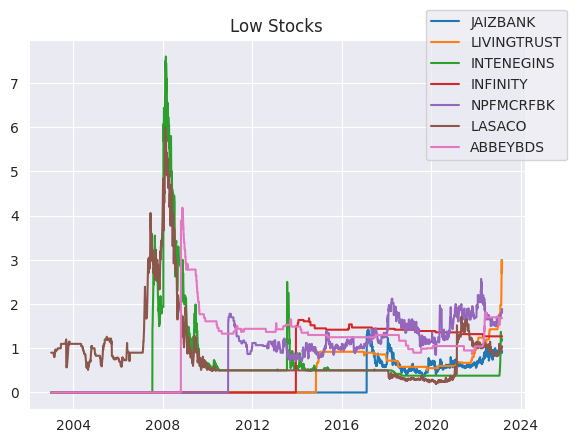

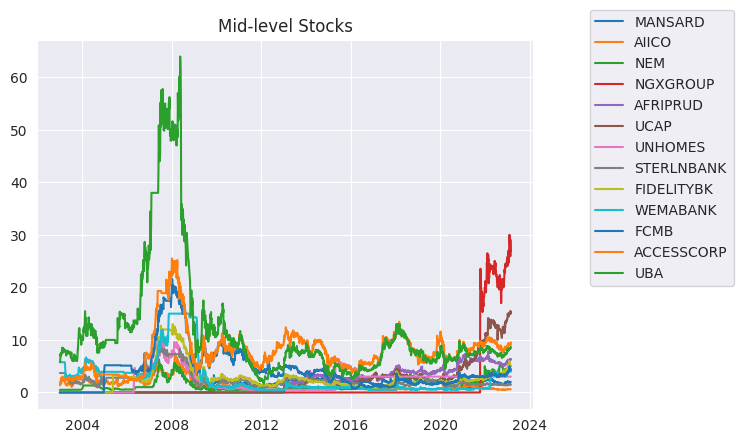

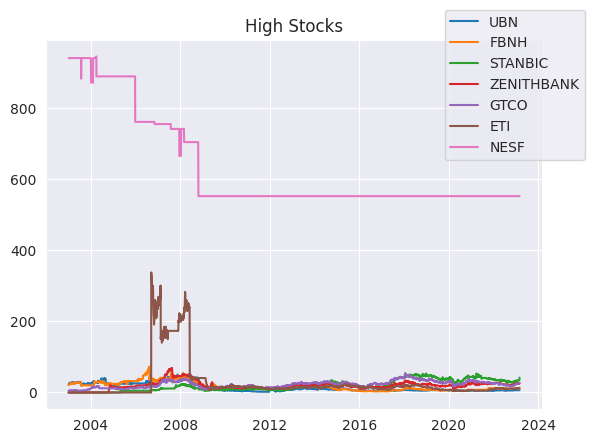

In [46]:
# financial_tsdata[low_vol_cols].plot.line()
plt.plot(financial_tsdata[low_vol_cols])
plt.legend(low_vol_cols, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.title("Low Stocks")
plt.show()

plt.plot(financial_tsdata[mid_vol_cols])
plt.legend(mid_vol_cols, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.title("Mid-level Stocks")
plt.show()

plt.plot(financial_tsdata[high_vol_cols])
plt.legend(high_vol_cols, loc='best', bbox_to_anchor=(1.1, 1.1))
plt.title("High Stocks")
plt.show()

# MODEL BUILDING

## hyperparameter tuning

these parameters that can be tuned;

1. <b>`changepoint_prior_scale`</b>
2. <b>`seasonality_prior_scale`</b>
3. <b>`holidays_prior_scale`</b>
4. <b>`seasonality_mode`</b>
5. <b>`changepoint_range`</b>

In [ ]:
changepoint_prior_scale_range = np.linspace(0.001, 0.5, num=5).tolist()
print(changepoint_prior_scale_range)

[0.001, 0.12575, 0.2505, 0.37525, 0.5]


In [ ]:
seasonality_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()
holidays_prior_scale_range = np.linspace(0.01, 10, num=5).tolist()

seasonality_mode_options = ['additive', 'multiplicative']
# changepoint_range_range = list(np.linspace(0.5, 0.95, num=5))

<hr>

<b>`NOTE:`</b><br> in order to determine the effective accuracy of the model, in prophet cross-validation, I have to cut off the data at various times within the dates (not including the `2003`), over a large timeframe, so as to normalize. This gives rise to the importance for <b>`cross-validation`</b>


## cross validation (prophet pipeline)

finding the <b>`"best"`</b> parameters by testing over various periods of time with those parameters (cross-validation)

In [ ]:
start_time = time.time()

dicts = {}

for feature in financial_tsdata.columns:

    stocksector_df = financial_tsdata[feature].copy().reset_index()
    stocksector_df.columns = ["ds", "y"]

    stocksector_df[["y"]] = stocksector_df[["y"]].apply(pd.to_numeric)
    stocksector_df["ds"] = pd.to_datetime(stocksector_df["ds"])

    param_grid = {
        "changepoint_prior_scale": changepoint_prior_scale_range,
        "seasonality_prior_scale": seasonality_prior_scale_range}
        #'holidays_prior_scale': holidays_prior_scale_range,
        #'seasonality_mode': seasonality_mode_options,
        #'changepoint_range': changepoint_range_range,

    # to generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    mapes = []

    # cross validation to evaluate all parameters
    for params in all_params:
      try:
        m = Prophet(**params).fit(stocksector_df)  # fit model with given params
        df_cv = cross_validation(m, initial="365.25 days", period="365.25 days", horizon = "30 days") #took parallel out
        df_p = performance_metrics(df_cv, rolling_window=1)
        # print(df_p)
        mapes.append(df_p["mape"].values[0])
      except Exception as e:
        print(f"Error for {feature}: {str(e)}")
        # Handle the error as needed, e.g., continue to the next parameter set or feature



    # Find the best parameters
    if len(mapes) > 0:
        tuning_results = pd.DataFrame(all_params)
        tuning_results["mape"] = mapes

        print(f"Results for {feature}:")
        print(tuning_results.head())

        params_dict = dict(tuning_results.sort_values("mape").reset_index(drop=True).iloc[0])
        params_dict["column"] = feature

        dicts[feature] = params_dict
    else:
        print(f"No valid results for {feature}")

print("--- %s seconds ---" % (time.time() - start_time))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/69jf_ktm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/7960wqhv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39663', 'data', 'file=/tmp/tmp71qqg74u/69jf_ktm.json', 'init=/tmp/tmp71qqg74u/7960wqhv.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_model690nzq_y/prophet_model-20230920090250.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:02:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:02:51 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 20 forecasts with cutoffs between 2004-01-29 06:00:00 and 2023-01-29 00:00:00


  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/g7ve2wqj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/vfia16zt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=20329', 'data', 'file=/tmp/tmp71qqg74u/g7ve2wqj.json', 'init=/tmp/tmp71qqg74u/vfia16zt.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_model69lipz5o/prophet_model-20230920090252.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:02:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:02:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/axye6sxv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/fuvtigm6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/k6uigjg3.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/_rr3uc3k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19825', 'data', 'file=/tmp/tmp71qqg74u/k6uigjg3.json', 'init=/tmp/tmp71qqg74u/_rr3uc3k.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelsnuvp5mb/prophet_model-20230920090307.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:03:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:03:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/227jrpkg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/yrgvnmet.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/wenx0doy.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/bmhfq0ei.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51775', 'data', 'file=/tmp/tmp71qqg74u/wenx0doy.json', 'init=/tmp/tmp71qqg74u/bmhfq0ei.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelpwi5xtbn/prophet_model-20230920090322.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:03:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:03:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/mcf4uqu8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/gnj9wnrx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/ssgq28rm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/ahain9mx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3291', 'data', 'file=/tmp/tmp71qqg74u/ssgq28rm.json', 'init=/tmp/tmp71qqg74u/ahain9mx.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelx4rpp8el/prophet_model-20230920090338.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:03:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:03:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/gy7f0pi1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/9baul95o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/82ipboru.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/9l12ra4r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9368', 'data', 'file=/tmp/tmp71qqg74u/82ipboru.json', 'init=/tmp/tmp71qqg74u/9l12ra4r.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_model0aj2w_ao/prophet_model-20230920090352.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:03:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:03:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/_kn_5jaz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/62z9p9h0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/ci73f0ul.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/prrxcsto.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13779', 'data', 'file=/tmp/tmp71qqg74u/ci73f0ul.json', 'init=/tmp/tmp71qqg74u/prrxcsto.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modele__6sqia/prophet_model-20230920090410.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:04:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:04:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/t3lh5tly.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/1aqhqyge.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/zfxwt24f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/_tv4qya1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14608', 'data', 'file=/tmp/tmp71qqg74u/zfxwt24f.json', 'init=/tmp/tmp71qqg74u/_tv4qya1.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelg_mov70f/prophet_model-20230920090522.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:05:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:05:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/6wt_elch.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/p39x_t7c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/_g90jvg8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/j4uzwg23.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4422', 'data', 'file=/tmp/tmp71qqg74u/_g90jvg8.json', 'init=/tmp/tmp71qqg74u/j4uzwg23.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelcg3eb340/prophet_model-20230920090640.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:06:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:06:42 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/6oz1n03o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/b5hkfmx0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/1mvxa38y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/wsbsqtc2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=62922', 'data', 'file=/tmp/tmp71qqg74u/1mvxa38y.json', 'init=/tmp/tmp71qqg74u/wsbsqtc2.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelo_eh2eaa/prophet_model-20230920090749.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:07:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:07:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/arewe2dd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/qxyey23l.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/wtrj_tot.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/6y8do9ey.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23905', 'data', 'file=/tmp/tmp71qqg74u/wtrj_tot.json', 'init=/tmp/tmp71qqg74u/6y8do9ey.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modele3ol82k0/prophet_model-20230920090904.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:09:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:09:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/dayr0uy6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/lfzmgvez.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/wwopx2h0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/oamqe9ti.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83779', 'data', 'file=/tmp/tmp71qqg74u/wwopx2h0.json', 'init=/tmp/tmp71qqg74u/oamqe9ti.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelkuxmv3b7/prophet_model-20230920091015.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:10:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:10:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/s6ms6se0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/nnmzhxu1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/2asz2nsl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/210g9aci.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76435', 'data', 'file=/tmp/tmp71qqg74u/2asz2nsl.json', 'init=/tmp/tmp71qqg74u/210g9aci.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelgu6nuy13/prophet_model-20230920091121.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:11:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:11:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/ntv2koxq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/djtfi_gw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/ikwzuwd_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/zotru7wc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5360', 'data', 'file=/tmp/tmp71qqg74u/ikwzuwd_.json', 'init=/tmp/tmp71qqg74u/zotru7wc.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelji_ujhz4/prophet_model-20230920091225.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:12:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:12:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/ps10_26b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/80_0mlfz.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/_99od59o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/53e6numl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99104', 'data', 'file=/tmp/tmp71qqg74u/_99od59o.json', 'init=/tmp/tmp71qqg74u/53e6numl.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_model18pf_hg1/prophet_model-20230920091332.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:13:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:13:34 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/h86ytu3e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/zb8m4vkv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/d6t2e9xs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/guyegyvp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=58536', 'data', 'file=/tmp/tmp71qqg74u/d6t2e9xs.json', 'init=/tmp/tmp71qqg74u/guyegyvp.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_model6wyqww_9/prophet_model-20230920091439.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:14:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:14:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/h6lgzf_j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/xgmpu0ya.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/twjsrny7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/exy31_k1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6081', 'data', 'file=/tmp/tmp71qqg74u/twjsrny7.json', 'init=/tmp/tmp71qqg74u/exy31_k1.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelk233qks9/prophet_model-20230920091541.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:15:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:15:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/zt_d5gcd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/ipkfyis9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/hfykkmix.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/q18u943u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68764', 'data', 'file=/tmp/tmp71qqg74u/hfykkmix.json', 'init=/tmp/tmp71qqg74u/q18u943u.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_model96d5un51/prophet_model-20230920091644.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:16:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:16:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/ensj2mao.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/d4m62ibi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/b0itgjpc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/3igh2thi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42974', 'data', 'file=/tmp/tmp71qqg74u/b0itgjpc.json', 'init=/tmp/tmp71qqg74u/3igh2thi.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelew4xircl/prophet_model-20230920091747.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:17:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:17:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/xz2jil1n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/xplg47h4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/m0m4dzr7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/7rhvi1av.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48154', 'data', 'file=/tmp/tmp71qqg74u/m0m4dzr7.json', 'init=/tmp/tmp71qqg74u/7rhvi1av.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelq3judyzy/prophet_model-20230920091850.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:18:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:18:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/y93pnzxa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/wscqgf48.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/d9luf3ob.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/464hj9ja.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45908', 'data', 'file=/tmp/tmp71qqg74u/d9luf3ob.json', 'init=/tmp/tmp71qqg74u/464hj9ja.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modeldcz5rfc8/prophet_model-20230920091954.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:19:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:19:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/tvli7w28.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/jrxr1yv1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/h16x8s5a.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/a3u71ill.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=82884', 'data', 'file=/tmp/tmp71qqg74u/h16x8s5a.json', 'init=/tmp/tmp71qqg74u/a3u71ill.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelxig4hrns/prophet_model-20230920092059.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:20:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:21:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/_rd4sao9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/1fu4y45m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/bxuel_5x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/f2y8cvmj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=43003', 'data', 'file=/tmp/tmp71qqg74u/bxuel_5x.json', 'init=/tmp/tmp71qqg74u/f2y8cvmj.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_model250y1i5k/prophet_model-20230920092203.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:22:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:22:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/6ivrfode.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/s1u2m2t2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/qu1_sl4d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/_jrprgjs.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4385', 'data', 'file=/tmp/tmp71qqg74u/qu1_sl4d.json', 'init=/tmp/tmp71qqg74u/_jrprgjs.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_model9zlzhcm4/prophet_model-20230920092310.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:23:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:23:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/onq6j2oh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/l20wn7wh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/25xr3tsd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/vbr5pxoa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59583', 'data', 'file=/tmp/tmp71qqg74u/25xr3tsd.json', 'init=/tmp/tmp71qqg74u/vbr5pxoa.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelqunlroea/prophet_model-20230920092413.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:24:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:24:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/g9_97e94.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/87hye7kg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/hmr8m909.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/enw_cvfc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2608', 'data', 'file=/tmp/tmp71qqg74u/hmr8m909.json', 'init=/tmp/tmp71qqg74u/enw_cvfc.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_model20be6u3u/prophet_model-20230920092518.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:25:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:25:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/9d1nyvk2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/jno9jf0e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Results for ELLAHLAKES:
   changepoint_prior_scale  seasonality_prior_scale      mape
0                    0.001                   0.0100  0.159215
1                    0.001                   2.5075  0.155245
2                    0.001                   5.0050  0.158290
3                    0.001                   7.5025  0.152337
4                    0.001                  10.0000  0.159111


DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/guzfeq9w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91671', 'data', 'file=/tmp/tmp71qqg74u/ovdpaech.json', 'init=/tmp/tmp71qqg74u/guzfeq9w.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelsnnaxdll/prophet_model-20230920092616.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:26:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:26:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 20 forecasts with cutoffs between 2004-01-29 06:00:00 and 2023-01-29 00:00:00


  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/c9mpc3zj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/nxh37p22.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=11948', 'data', 'file=/tmp/tmp71qqg74u/c9mpc3zj.json', 'init=/tmp/tmp71qqg74u/nxh37p22.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modeldvrs0epd/prophet_model-20230920092617.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:26:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:26:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/hf01ne4j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/4bhpriq4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/9grlx1cj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/l1257nhf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=6427', 'data', 'file=/tmp/tmp71qqg74u/9grlx1cj.json', 'init=/tmp/tmp71qqg74u/l1257nhf.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelv43oc93j/prophet_model-20230920092631.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:26:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:26:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/octz7d4c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/y1oilts5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/aj8v0sdv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/mbv04cy4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87968', 'data', 'file=/tmp/tmp71qqg74u/aj8v0sdv.json', 'init=/tmp/tmp71qqg74u/mbv04cy4.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelrmazuyfr/prophet_model-20230920092645.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:26:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:26:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/74hcki5c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/8m6d2p4h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/n2vempgb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/7vtnyrvh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=19971', 'data', 'file=/tmp/tmp71qqg74u/n2vempgb.json', 'init=/tmp/tmp71qqg74u/7vtnyrvh.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelt236neza/prophet_model-20230920092658.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:26:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:26:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/nuc9axw7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/tdlqyums.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/93ax6e3h.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/oy6mifuv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38045', 'data', 'file=/tmp/tmp71qqg74u/93ax6e3h.json', 'init=/tmp/tmp71qqg74u/oy6mifuv.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelbs250xiv/prophet_model-20230920092712.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:27:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:27:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/9a9b0s3j.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/aof5l62b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/dhc1zxd5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/7o6w3ooh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42463', 'data', 'file=/tmp/tmp71qqg74u/dhc1zxd5.json', 'init=/tmp/tmp71qqg74u/7o6w3ooh.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modele4tew493/prophet_model-20230920092730.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:27:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:27:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/tc_ph8ne.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/anq8jx7e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/1dpbht2b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/9ox5g5bo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38026', 'data', 'file=/tmp/tmp71qqg74u/1dpbht2b.json', 'init=/tmp/tmp71qqg74u/9ox5g5bo.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_model6s1q9lqy/prophet_model-20230920092835.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:28:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:28:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/1pgz2pt4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/l1yu3pvr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/vmdzqjht.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/x5kevnvi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=16794', 'data', 'file=/tmp/tmp71qqg74u/vmdzqjht.json', 'init=/tmp/tmp71qqg74u/x5kevnvi.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelreq34w3k/prophet_model-20230920092944.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:29:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:29:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/l9vrii6x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/ws1msc1e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/itl9sdjc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/lnz883yd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21030', 'data', 'file=/tmp/tmp71qqg74u/itl9sdjc.json', 'init=/tmp/tmp71qqg74u/lnz883yd.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelgp8ynqku/prophet_model-20230920093054.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:30:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:30:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/0t7swqe9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/_wbyow3i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/hj9cha4g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/qdheqvoh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37484', 'data', 'file=/tmp/tmp71qqg74u/hj9cha4g.json', 'init=/tmp/tmp71qqg74u/qdheqvoh.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelwif5eiz6/prophet_model-20230920093200.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:32:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:32:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/d5q_bzzc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/anvzye8q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/i5krgkst.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/_duq6h1v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54701', 'data', 'file=/tmp/tmp71qqg74u/i5krgkst.json', 'init=/tmp/tmp71qqg74u/_duq6h1v.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modeltj5q6yl6/prophet_model-20230920093305.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:33:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:33:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/6vfepw3n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/0k73l507.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/qn1vy5g9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/75d3nuok.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42937', 'data', 'file=/tmp/tmp71qqg74u/qn1vy5g9.json', 'init=/tmp/tmp71qqg74u/75d3nuok.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modellw3ipyj8/prophet_model-20230920093411.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:34:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:34:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/14or0vpa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/8smdtjaa.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/r12tx5kl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/b6oozb2b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31971', 'data', 'file=/tmp/tmp71qqg74u/r12tx5kl.json', 'init=/tmp/tmp71qqg74u/b6oozb2b.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelg554k_7h/prophet_model-20230920093521.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:35:21 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:35:21 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/26_oiyzq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/fdjtw7ja.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/j7zv6a38.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/7m0vmcel.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14905', 'data', 'file=/tmp/tmp71qqg74u/j7zv6a38.json', 'init=/tmp/tmp71qqg74u/7m0vmcel.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_model6y36jsjh/prophet_model-20230920093628.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:36:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:36:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/vju28exc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/r11cqqrp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/sk48qvz4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/198bn3z4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54303', 'data', 'file=/tmp/tmp71qqg74u/sk48qvz4.json', 'init=/tmp/tmp71qqg74u/198bn3z4.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_model6et3qsib/prophet_model-20230920093735.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:37:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:37:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/coelcjok.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/hdf1qp8e.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/j13550bi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/c6l0r4pt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13516', 'data', 'file=/tmp/tmp71qqg74u/j13550bi.json', 'init=/tmp/tmp71qqg74u/c6l0r4pt.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelw_fg64h0/prophet_model-20230920093843.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:38:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:38:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/xgkoi5uw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/1vjlfflh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/3z2kw4j2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/tfr0tdla.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1953', 'data', 'file=/tmp/tmp71qqg74u/3z2kw4j2.json', 'init=/tmp/tmp71qqg74u/tfr0tdla.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelmx8jqr0w/prophet_model-20230920093947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:39:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:39:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/zum48wlr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/hklpn8c3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/do8jyjtb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/3352qnr_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49272', 'data', 'file=/tmp/tmp71qqg74u/do8jyjtb.json', 'init=/tmp/tmp71qqg74u/3352qnr_.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelo866c3ok/prophet_model-20230920094053.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:40:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:40:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/7hdvgbt4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/k3ykg3xg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/84fvnove.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/hym1jo6_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83562', 'data', 'file=/tmp/tmp71qqg74u/84fvnove.json', 'init=/tmp/tmp71qqg74u/hym1jo6_.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_model4e5s47yd/prophet_model-20230920094159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:41:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:41:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/fhtcl9ti.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/6lv24n13.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/mb7oc4dm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/a3yk60rn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=9908', 'data', 'file=/tmp/tmp71qqg74u/mb7oc4dm.json', 'init=/tmp/tmp71qqg74u/a3yk60rn.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelxyaas5t4/prophet_model-20230920094305.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:43:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:43:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/78qkts2u.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/o308dd54.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/uoz4gp4e.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/4w1svcd4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53568', 'data', 'file=/tmp/tmp71qqg74u/uoz4gp4e.json', 'init=/tmp/tmp71qqg74u/4w1svcd4.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelk9oq64lr/prophet_model-20230920094410.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:44:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:44:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/_6ivrcdh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/gedneamp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/9sx47m3n.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/c9nfo65c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39148', 'data', 'file=/tmp/tmp71qqg74u/9sx47m3n.json', 'init=/tmp/tmp71qqg74u/c9nfo65c.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelgw6yxosu/prophet_model-20230920094517.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:45:17 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:45:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/zd74yl1t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/zeaqvc2f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/z7tqze4i.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/e14w778t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54211', 'data', 'file=/tmp/tmp71qqg74u/z7tqze4i.json', 'init=/tmp/tmp71qqg74u/e14w778t.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_model44mh9k1h/prophet_model-20230920094622.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:46:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:46:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/lz_xd0k6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/ubyb2za8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/8d6ko10b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/i_5qenug.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4333', 'data', 'file=/tmp/tmp71qqg74u/8d6ko10b.json', 'init=/tmp/tmp71qqg74u/i_5qenug.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelantgj9t0/prophet_model-20230920094728.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:47:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:47:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/thp3l14s.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/_gmvp4br.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/rbewu7wt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/zmdak89f.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92306', 'data', 'file=/tmp/tmp71qqg74u/rbewu7wt.json', 'init=/tmp/tmp71qqg74u/zmdak89f.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_model2vdwibib/prophet_model-20230920094835.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:48:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:48:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/2ezr6j67.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/iu25td56.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Results for LIVESTOCK:
   changepoint_prior_scale  seasonality_prior_scale      mape
0                    0.001                   0.0100  0.676012
1                    0.001                   2.5075  0.657427
2                    0.001                   5.0050  0.685862
3                    0.001                   7.5025  0.687929
4                    0.001                  10.0000  0.662578


DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/roziixd_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39962', 'data', 'file=/tmp/tmp71qqg74u/n9xzvfqg.json', 'init=/tmp/tmp71qqg74u/roziixd_.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_model0fdke_sv/prophet_model-20230920094938.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:49:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:49:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 20 forecasts with cutoffs between 2004-01-29 06:00:00 and 2023-01-29 00:00:00


  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/93jbwluu.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/c3bv__u3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=825', 'data', 'file=/tmp/tmp71qqg74u/93jbwluu.json', 'init=/tmp/tmp71qqg74u/c3bv__u3.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelhfb_lj92/prophet_model-20230920094939.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:49:39 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:49:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
09:49:39 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/doc_v21z.json
DEBU

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/mfpfvokk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/k6dzjf64.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53868', 'data', 'file=/tmp/tmp71qqg74u/mfpfvokk.json', 'init=/tmp/tmp71qqg74u/k6dzjf64.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_model0flicazf/prophet_model-20230920094956.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:49:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:49:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
09:49:56 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/l1rsdjrt.json
DE

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/w5ci9c96.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/0n40q1xw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98234', 'data', 'file=/tmp/tmp71qqg74u/w5ci9c96.json', 'init=/tmp/tmp71qqg74u/0n40q1xw.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelludbqlr2/prophet_model-20230920095011.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:50:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:50:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
09:50:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/z44wvl9_.json
DE

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/8jn9i7vm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/gv7jheu_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=80436', 'data', 'file=/tmp/tmp71qqg74u/8jn9i7vm.json', 'init=/tmp/tmp71qqg74u/gv7jheu_.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelb76gy8e0/prophet_model-20230920095027.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:50:27 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:50:27 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
09:50:27 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/codh0eis.json
DE

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/crvtzyc6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/5bx8jscb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95270', 'data', 'file=/tmp/tmp71qqg74u/crvtzyc6.json', 'init=/tmp/tmp71qqg74u/5bx8jscb.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelzwjpwucb/prophet_model-20230920095043.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:50:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:50:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
09:50:43 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/6989h66s.json
DE

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/ag0kn3if.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/u2og2ots.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2294', 'data', 'file=/tmp/tmp71qqg74u/ag0kn3if.json', 'init=/tmp/tmp71qqg74u/u2og2ots.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelxut3gcw6/prophet_model-20230920095103.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:51:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:51:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/g118dr57.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/2ynows4w.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/wdm9wgm5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/tctokyoy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57638', 'data', 'file=/tmp/tmp71qqg74u/wdm9wgm5.json', 'init=/tmp/tmp71qqg74u/tctokyoy.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelj17vmelv/prophet_model-20230920095200.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:52:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:52:00 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/lustelle.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/37n6yfwv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/lqq3yime.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/1ng06pkm.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74339', 'data', 'file=/tmp/tmp71qqg74u/lqq3yime.json', 'init=/tmp/tmp71qqg74u/1ng06pkm.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_model738mpn99/prophet_model-20230920095257.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:52:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:52:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/1w6mxtor.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/pnnf_i6x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/xfymbyx9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/y7txyu0t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31676', 'data', 'file=/tmp/tmp71qqg74u/xfymbyx9.json', 'init=/tmp/tmp71qqg74u/y7txyu0t.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_model86w0aihi/prophet_model-20230920095355.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:53:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:53:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/onymx54r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/hgurpx1j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/00qnuae9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/ay8qvpff.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76238', 'data', 'file=/tmp/tmp71qqg74u/00qnuae9.json', 'init=/tmp/tmp71qqg74u/ay8qvpff.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelnbaqi5yr/prophet_model-20230920095453.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:54:53 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:54:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/1zkok_jz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/9q3vk54j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/0ydp4la2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/so3f202m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37223', 'data', 'file=/tmp/tmp71qqg74u/0ydp4la2.json', 'init=/tmp/tmp71qqg74u/so3f202m.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelouh4nngu/prophet_model-20230920095548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:55:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:55:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/hb4h1g0q.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/emecizxg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/kb42rbve.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/04yqhvxt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=81938', 'data', 'file=/tmp/tmp71qqg74u/kb42rbve.json', 'init=/tmp/tmp71qqg74u/04yqhvxt.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelrjmjlz8x/prophet_model-20230920095647.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:56:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:56:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/o55z3acz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/1wrz1aun.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/4ijywj_5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/9fkjgcb1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=37178', 'data', 'file=/tmp/tmp71qqg74u/4ijywj_5.json', 'init=/tmp/tmp71qqg74u/9fkjgcb1.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelhb2oxm5w/prophet_model-20230920095744.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:57:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:57:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/fi6c9xxh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/da02puo9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/o6kpntog.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/7awn584q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54241', 'data', 'file=/tmp/tmp71qqg74u/o6kpntog.json', 'init=/tmp/tmp71qqg74u/7awn584q.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelv1_ljkjf/prophet_model-20230920095847.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:58:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:58:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/rsrtznep.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/iv95lwhq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/luv4js6x.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/tgkxlxgv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87195', 'data', 'file=/tmp/tmp71qqg74u/luv4js6x.json', 'init=/tmp/tmp71qqg74u/tgkxlxgv.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modeldm3dv20a/prophet_model-20230920095947.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:59:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:59:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/byh_7_v6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/ztzs_z7m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/97gd9p3g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/8g54glor.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86572', 'data', 'file=/tmp/tmp71qqg74u/97gd9p3g.json', 'init=/tmp/tmp71qqg74u/8g54glor.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelu794qvwi/prophet_model-20230920100045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:00:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:00:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/keuy2nfi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/cvpfc2nh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/4n1vos59.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/80dq75br.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=69648', 'data', 'file=/tmp/tmp71qqg74u/4n1vos59.json', 'init=/tmp/tmp71qqg74u/80dq75br.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modeloq0auoaj/prophet_model-20230920100147.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:01:47 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:01:47 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/uvw82cwi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/wbp3eatp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/s9ql53sv.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/rt6_juve.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38920', 'data', 'file=/tmp/tmp71qqg74u/s9ql53sv.json', 'init=/tmp/tmp71qqg74u/rt6_juve.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelo2x3p55y/prophet_model-20230920100249.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:02:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:02:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/pzf__vne.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/7ns06idy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/_gjfo7wn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/vntszk_o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24361', 'data', 'file=/tmp/tmp71qqg74u/_gjfo7wn.json', 'init=/tmp/tmp71qqg74u/vntszk_o.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_model8f_a0jkk/prophet_model-20230920100349.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:03:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:03:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/39nd2_1w.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/uzw77_3v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/slobyngq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/d6lzotgd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44399', 'data', 'file=/tmp/tmp71qqg74u/slobyngq.json', 'init=/tmp/tmp71qqg74u/d6lzotgd.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelwz7b0ku3/prophet_model-20230920100449.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:04:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:04:49 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/7uok2wbn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/0eb_1lz_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/cg4s4bjf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/h1sql5ww.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42847', 'data', 'file=/tmp/tmp71qqg74u/cg4s4bjf.json', 'init=/tmp/tmp71qqg74u/h1sql5ww.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelwl1q3j8s/prophet_model-20230920100552.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:05:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:05:53 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/yrol5e8z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/060ejnyv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/t_ch9y_p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/yhiv84uv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14625', 'data', 'file=/tmp/tmp71qqg74u/t_ch9y_p.json', 'init=/tmp/tmp71qqg74u/yhiv84uv.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_model520eqvwz/prophet_model-20230920100655.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:06:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:06:55 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/0p7p1znf.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/93kxln_o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/ivztksat.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/o40g4apg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=76692', 'data', 'file=/tmp/tmp71qqg74u/ivztksat.json', 'init=/tmp/tmp71qqg74u/o40g4apg.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelqnp2rit0/prophet_model-20230920100757.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:07:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:07:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/1xp9a1du.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/t_48y5nn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/kt1v9w0v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/0phm1s4o.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48350', 'data', 'file=/tmp/tmp71qqg74u/kt1v9w0v.json', 'init=/tmp/tmp71qqg74u/0phm1s4o.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelhex9e0sl/prophet_model-20230920100900.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:09:00 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:09:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/oqdvymjc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/quw97t99.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/sbtgqkei.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/5g_vcpyv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4675', 'data', 'file=/tmp/tmp71qqg74u/sbtgqkei.json', 'init=/tmp/tmp71qqg74u/5g_vcpyv.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modeldfg9v5i9/prophet_model-20230920101005.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:10:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:10:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/7z2qw8o5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/p74zgwdr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

Results for OKOMUOIL:
   changepoint_prior_scale  seasonality_prior_scale      mape
0                    0.001                   0.0100  0.306605
1                    0.001                   2.5075  0.307833
2                    0.001                   5.0050  0.310496
3                    0.001                   7.5025  0.306796
4                    0.001                  10.0000  0.306703


DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/ullapvzq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48369', 'data', 'file=/tmp/tmp71qqg74u/_3fxe7vf.json', 'init=/tmp/tmp71qqg74u/ullapvzq.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelicavtaya/prophet_model-20230920101103.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:11:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:11:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 20 forecasts with cutoffs between 2004-01-29 06:00:00 and 2023-01-29 00:00:00


  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/w3z3ztpj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/pk6di8ou.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40787', 'data', 'file=/tmp/tmp71qqg74u/w3z3ztpj.json', 'init=/tmp/tmp71qqg74u/pk6di8ou.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelonwahu32/prophet_model-20230920101105.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:11:05 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:11:05 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
10:11:05 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/n6wr1xdz.json
DE

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/wzy435qr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/790jgc0b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7293', 'data', 'file=/tmp/tmp71qqg74u/wzy435qr.json', 'init=/tmp/tmp71qqg74u/790jgc0b.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelbahw2egl/prophet_model-20230920101122.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:11:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:11:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
10:11:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/3ix0veun.json
DEB

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/afa3qiym.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/9nhfvr4t.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7222', 'data', 'file=/tmp/tmp71qqg74u/afa3qiym.json', 'init=/tmp/tmp71qqg74u/9nhfvr4t.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_model3mvrhyx1/prophet_model-20230920101140.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:11:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:11:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
10:11:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/2y40i1mj.json
DEB

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/843xgixn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/6cpmaod4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=57900', 'data', 'file=/tmp/tmp71qqg74u/843xgixn.json', 'init=/tmp/tmp71qqg74u/6cpmaod4.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_model8_t1pc_6/prophet_model-20230920101159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:11:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:11:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
10:11:59 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/fn9s7slg.json
DE

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/y2bfuj1g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/cot9jesc.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99836', 'data', 'file=/tmp/tmp71qqg74u/y2bfuj1g.json', 'init=/tmp/tmp71qqg74u/cot9jesc.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modela0gsl953/prophet_model-20230920101216.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:12:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:12:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
10:12:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
ERROR:cmdstanpy:Chain [1] error: error during processing Operation not permitted
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/837_v5sj.json
DE

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/7lcnh7rr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/r81wfk_s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51592', 'data', 'file=/tmp/tmp71qqg74u/7lcnh7rr.json', 'init=/tmp/tmp71qqg74u/r81wfk_s.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_model_2ea7jer/prophet_model-20230920101237.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:12:37 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:12:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/t26ftcc9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/k88l3a5i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/kzso6qmh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/tm5u56aw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90343', 'data', 'file=/tmp/tmp71qqg74u/kzso6qmh.json', 'init=/tmp/tmp71qqg74u/tm5u56aw.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelo0tl4_nr/prophet_model-20230920101328.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:13:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:13:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/7jurjzs4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/b6uwg7l5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/7jstlmp7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/y3r2imfo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7252', 'data', 'file=/tmp/tmp71qqg74u/7jstlmp7.json', 'init=/tmp/tmp71qqg74u/y3r2imfo.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_model2lw_ez3w/prophet_model-20230920101422.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:14:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:14:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/01urua1c.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/6880fxm0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/ahdtuv7o.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/xec5yf48.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2921', 'data', 'file=/tmp/tmp71qqg74u/ahdtuv7o.json', 'init=/tmp/tmp71qqg74u/xec5yf48.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelvjmai6yo/prophet_model-20230920101519.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:15:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:15:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/dcm3_0ba.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/pzf352qj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/0l6ztwok.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/eni1rgkl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54699', 'data', 'file=/tmp/tmp71qqg74u/0l6ztwok.json', 'init=/tmp/tmp71qqg74u/eni1rgkl.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_model3rsrpls7/prophet_model-20230920101616.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:16:16 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:16:16 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/79k7vmbl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/_s6qoehi.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/azp40l3p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/qs98e722.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36505', 'data', 'file=/tmp/tmp71qqg74u/azp40l3p.json', 'init=/tmp/tmp71qqg74u/qs98e722.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelt7oo8ogv/prophet_model-20230920101709.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/2kz7t6rh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/0maccxu8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/_akmaph6.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/9b12jg4k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59737', 'data', 'file=/tmp/tmp71qqg74u/_akmaph6.json', 'init=/tmp/tmp71qqg74u/9b12jg4k.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modellf9qsyve/prophet_model-20230920101807.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:18:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:18:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/160fhtny.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/e9ea6yop.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/kdcc1mk4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/fbvuh5wy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77357', 'data', 'file=/tmp/tmp71qqg74u/kdcc1mk4.json', 'init=/tmp/tmp71qqg74u/fbvuh5wy.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_model572fsbmj/prophet_model-20230920101903.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:03 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:19:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/dwxxac6t.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/15270ocv.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/ur3f9_ly.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/94f42r4c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41285', 'data', 'file=/tmp/tmp71qqg74u/ur3f9_ly.json', 'init=/tmp/tmp71qqg74u/94f42r4c.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelj6q4vn_u/prophet_model-20230920102001.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/i4rjantm.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/um5pv2yu.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/_wugczdq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/ejdd_d_i.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=90820', 'data', 'file=/tmp/tmp71qqg74u/_wugczdq.json', 'init=/tmp/tmp71qqg74u/ejdd_d_i.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelrje_1x08/prophet_model-20230920102059.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:20:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:20:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/whbwa09z.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/qq3rbi6b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/lpkl6xlh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/gjmo69pt.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=83467', 'data', 'file=/tmp/tmp71qqg74u/lpkl6xlh.json', 'init=/tmp/tmp71qqg74u/gjmo69pt.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelymgm2fha/prophet_model-20230920102158.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:21:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:21:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/462j_zfe.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/63iw89f0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/0joybfow.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/z599q4cg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=14417', 'data', 'file=/tmp/tmp71qqg74u/0joybfow.json', 'init=/tmp/tmp71qqg74u/z599q4cg.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelmjh_lnj9/prophet_model-20230920102258.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:22:58 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:22:58 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/mijqtpj0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/w8o65m8k.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/yan1q8pj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/wikoej15.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=30929', 'data', 'file=/tmp/tmp71qqg74u/yan1q8pj.json', 'init=/tmp/tmp71qqg74u/wikoej15.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_model3lcxerlv/prophet_model-20230920102357.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:23:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:23:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/yc9bbnf8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/uq0ldvcl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/t5w9wjo9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/a10ikdxh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=59079', 'data', 'file=/tmp/tmp71qqg74u/t5w9wjo9.json', 'init=/tmp/tmp71qqg74u/a10ikdxh.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_model1yobefi6/prophet_model-20230920102457.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:24:57 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:24:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/2iy1ngye.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/zwr8q6_d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/efea6zij.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/h3cwptvb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74803', 'data', 'file=/tmp/tmp71qqg74u/efea6zij.json', 'init=/tmp/tmp71qqg74u/h3cwptvb.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelf3n0zhvg/prophet_model-20230920102556.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:25:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:25:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/hfw1_8gw.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/patkt6_0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/sf9gdei4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/ru8mjqc4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=1226', 'data', 'file=/tmp/tmp71qqg74u/sf9gdei4.json', 'init=/tmp/tmp71qqg74u/ru8mjqc4.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelosprmjxn/prophet_model-20230920102656.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:26:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:26:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/ikb84pps.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/f_8qtl8h.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/8fhd9s35.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/tcnxmn_u.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8664', 'data', 'file=/tmp/tmp71qqg74u/8fhd9s35.json', 'init=/tmp/tmp71qqg74u/tcnxmn_u.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modeluk72t199/prophet_model-20230920102756.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:27:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:27:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/egxg7_oq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/xpzmg85y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/l

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/0l2zka1b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/58fas3fy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77859', 'data', 'file=/tmp/tmp71qqg74u/0l2zka1b.json', 'init=/tmp/tmp71qqg74u/58fas3fy.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelm72oj0rc/prophet_model-20230920102855.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:28:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:28:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/upsgymjg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/upkigds6.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/lidzqz65.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/a_6pkr46.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55452', 'data', 'file=/tmp/tmp71qqg74u/lidzqz65.json', 'init=/tmp/tmp71qqg74u/a_6pkr46.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelm1ld4juy/prophet_model-20230920102954.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:29:54 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:29:54 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/pueoqq2l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/aax75vb1.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

  0%|          | 0/20 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/16z20d6_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/qreeivz4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49245', 'data', 'file=/tmp/tmp71qqg74u/16z20d6_.json', 'init=/tmp/tmp71qqg74u/qreeivz4.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelpn09qmkx/prophet_model-20230920103056.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:30:56 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:30:56 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/kb9mi_6v.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/ibj3o8bb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

Results for PRESCO:
   changepoint_prior_scale  seasonality_prior_scale      mape
0                    0.001                   0.0100  0.347057
1                    0.001                   2.5075  0.352872
2                    0.001                   5.0050  0.352008
3                    0.001                   7.5025  0.348627
4                    0.001                  10.0000  0.359179
--- 5340.466691017151 seconds ---


<b>`"df_p"`</b> gives the overall MAPE, but if you want to get more granular and calculate the daily differences using the mape metric, the code is below. This allows you to detect issues in predicting certain time periods, which are inherent issues in the data that you may or may not be able to fix.

In [ ]:
#how to call params_dict for a feature

dicts

{'ELLAHLAKES': {'changepoint_prior_scale': 0.12575,
  'seasonality_prior_scale': 0.01,
  'mape': 0.010959135146550449,
  'column': 'ELLAHLAKES'},
 'LIVESTOCK': {'changepoint_prior_scale': 0.12575,
  'seasonality_prior_scale': 10.0,
  'mape': 0.5167601887861509,
  'column': 'LIVESTOCK'},
 'OKOMUOIL': {'changepoint_prior_scale': 0.5,
  'seasonality_prior_scale': 0.01,
  'mape': 0.15687331971543478,
  'column': 'OKOMUOIL'},
 'PRESCO': {'changepoint_prior_scale': 0.5,
  'seasonality_prior_scale': 2.5075,
  'mape': 0.2259685011103176,
  'column': 'PRESCO'}}

## feature engineering by `holidays`

In [ ]:
#adding holiday data

holiday = pd.DataFrame([])

nigeria_holidays = holidays.NG()  # this is a dict
# the below is the same, but takes a string:
nigeria_holidays = holidays.country_holidays('NG')  # this is a dict


for date_, name in sorted(holidays.NG(years=[2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023]).items()):
    holiday = pd.concat([holiday, pd.DataFrame({'ds': date_, 'holiday': "NG-Holidays", 'lower_window': -2, 'upper_window': 1}, index=[0])], ignore_index=True)

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')
holiday.head()

ds      holiday  lower_window  upper_window
0 2003-01-01  NG-Holidays            -2             1
1 2003-02-11  NG-Holidays            -2             1
2 2003-02-12  NG-Holidays            -2             1
3 2003-04-18  NG-Holidays            -2             1
4 2003-04-21  NG-Holidays            -2             1

## backtesting with tuned metrics
`latest month up-to-date mape`

In [ ]:
prediction_days = 30
forecast_start_date = max(financial_tsdata.index) - timedelta(prediction_days)

<b>Note:</b> check a documentation here (reference to repo)!

In [ ]:
# PROPHET MODEL

forecasted_tsdata = []

for feature in financial_tsdata.columns:

    # prophet formats
    df_financial_copy = financial_tsdata[feature].copy().reset_index()
    df_financial_copy.columns = ['ds', 'y']
    df_financial_copy[['y']] = df_financial_copy[['y']].apply(pd.to_numeric)
    df_financial_copy['ds'] = pd.to_datetime(df_financial_copy['ds'])

    df_financial_copy_train = df_financial_copy[df_financial_copy['ds'] < forecast_start_date]

    # search & get the right param_dict for this sector
    param_dict = dicts[feature]

    # model
    model = Prophet(changepoint_prior_scale = dicts[feature]['changepoint_prior_scale'],
                   seasonality_prior_scale = dicts[feature]['seasonality_prior_scale'],
                   holidays = holiday)

    model.fit(df_financial_copy_train)

    future = model.make_future_dataframe(periods=prediction_days)
    fcst_prophet_train = m.predict(future)

    filter = fcst_prophet_train['ds'] >= forecast_start_date
    predicted_financial_df = fcst_prophet_train[filter][['ds', 'yhat']]
    predicted_financial_df = predicted_financial_df.merge(df_financial_copy)

    print(feature, mape(predicted_financial_df['y'], predicted_financial_df['yhat']))

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/e4hw4lgi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/w0o70qs8.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=49835', 'data', 'file=/tmp/tmp71qqg74u/e4hw4lgi.json', 'init=/tmp/tmp71qqg74u/w0o70qs8.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelqv43dzvv/prophet_model-20230920103150.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:31:50 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:31:57 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71

ELLAHLAKES 3372.041846359928


DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/ummhwdc_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=64911', 'data', 'file=/tmp/tmp71qqg74u/_b3kmjgj.json', 'init=/tmp/tmp71qqg74u/ummhwdc_.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_model6apw63il/prophet_model-20230920103159.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:31:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:32:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/m0ywhz14.json


LIVESTOCK 12764.992048456555


DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/r9h2vwtn.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13387', 'data', 'file=/tmp/tmp71qqg74u/m0ywhz14.json', 'init=/tmp/tmp71qqg74u/r9h2vwtn.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_model2naz9zal/prophet_model-20230920103206.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:32:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:32:11 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/ckracfya.json


OKOMUOIL 24.105664842262613


DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/hfltfh69.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=99137', 'data', 'file=/tmp/tmp71qqg74u/ckracfya.json', 'init=/tmp/tmp71qqg74u/hfltfh69.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelgd19lki4/prophet_model-20230920103213.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:32:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:32:17 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


PRESCO 8.824365307789666


In [ ]:
# Check the column names in the DataFrame
print(fcst_prophet_train.columns)


Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')


# FINAL FORECASTING

## forecast pipeline!!!

In [ ]:
days_of_prediction = 672
start_date_of_forecast = max(financial_tsdata.index)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/w0jio1re.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71qqg74u/3h54t_ui.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=22984', 'data', 'file=/tmp/tmp71qqg74u/w0jio1re.json', 'init=/tmp/tmp71qqg74u/3h54t_ui.json', 'output', 'file=/tmp/tmp71qqg74u/prophet_modelu30o4qpr/prophet_model-20230920103532.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:35:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:35:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp71

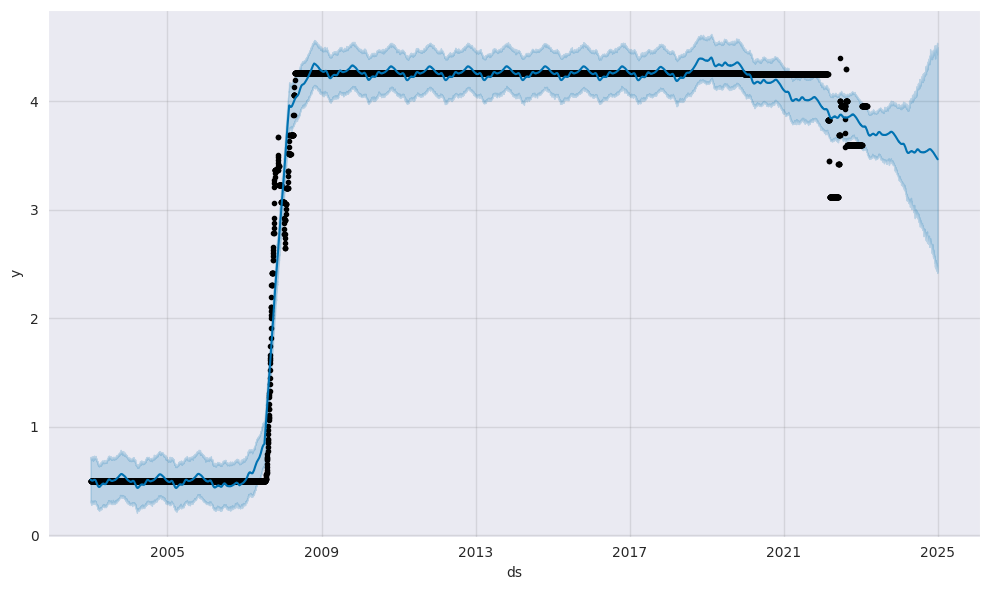

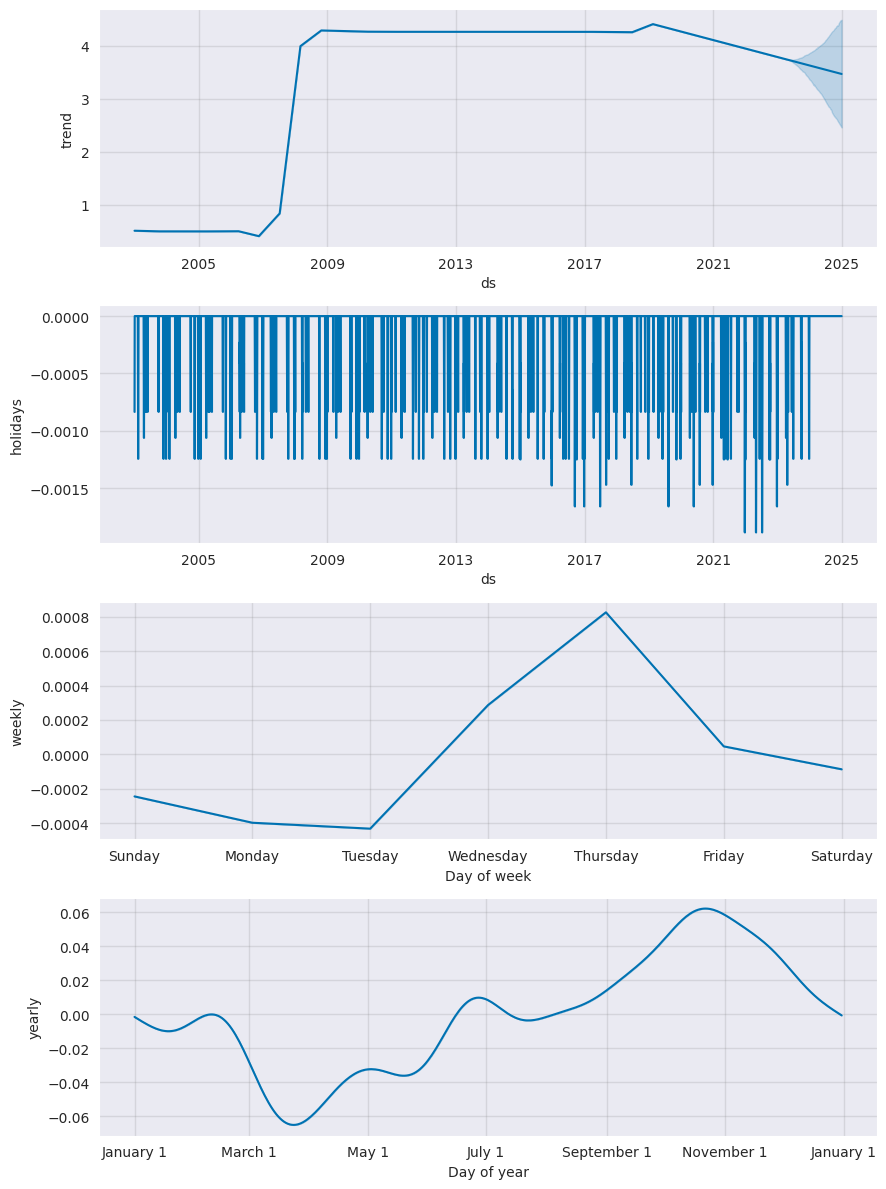

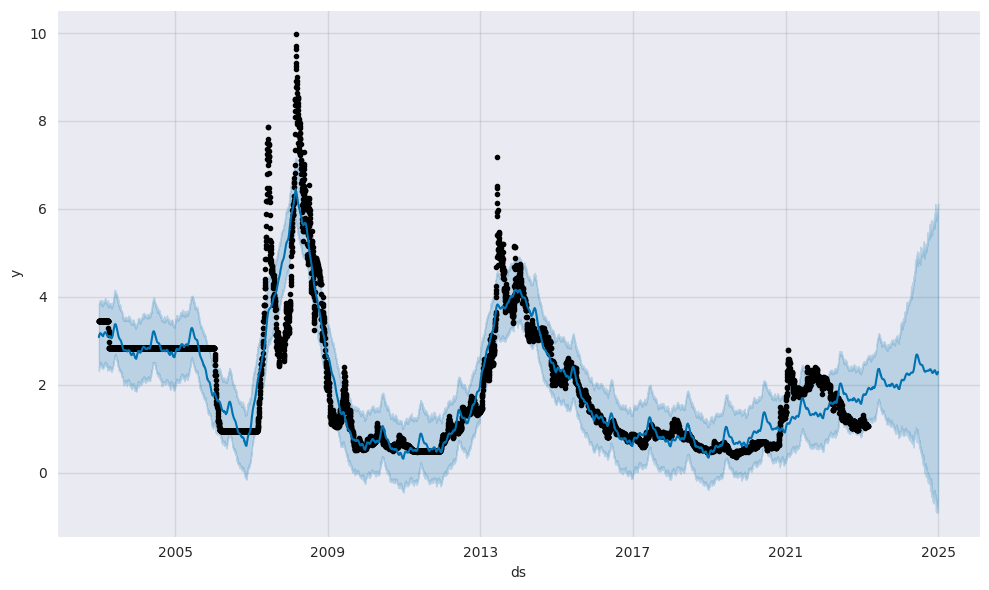

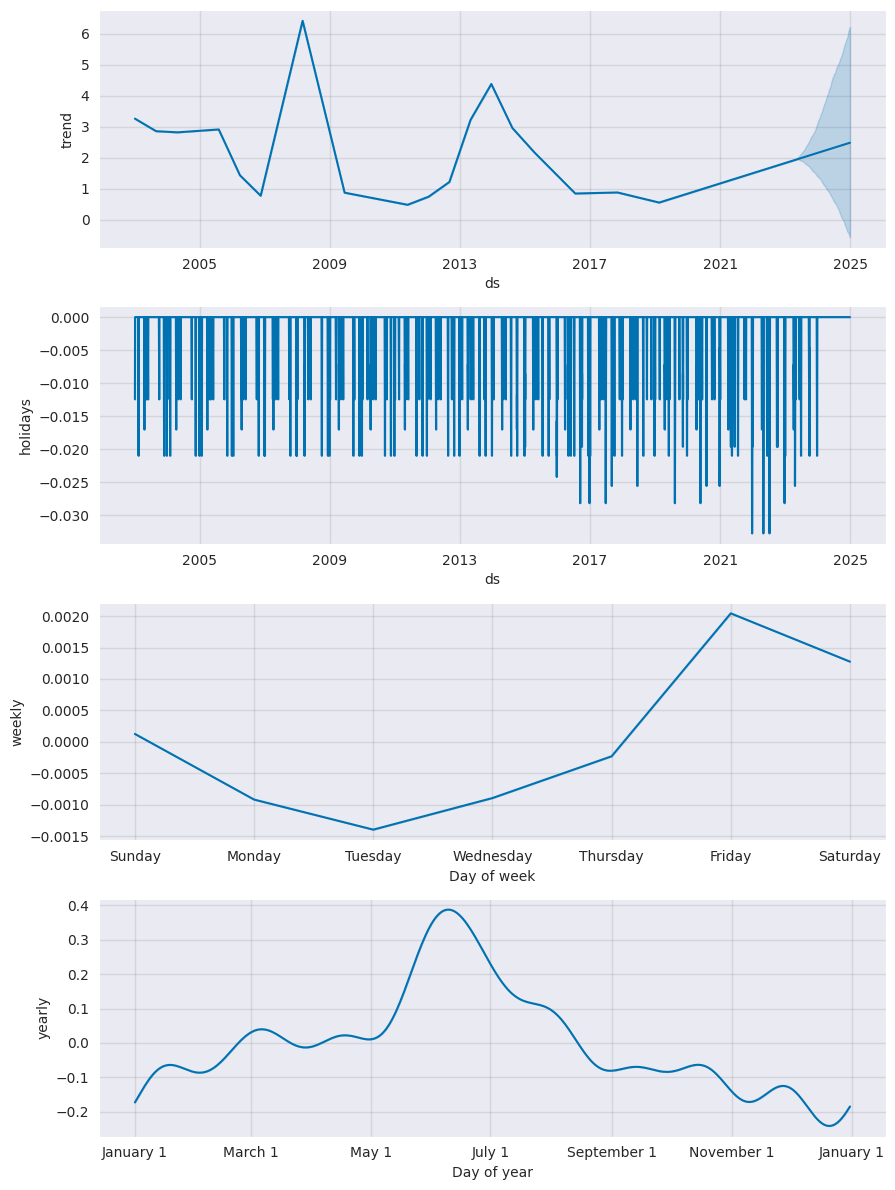

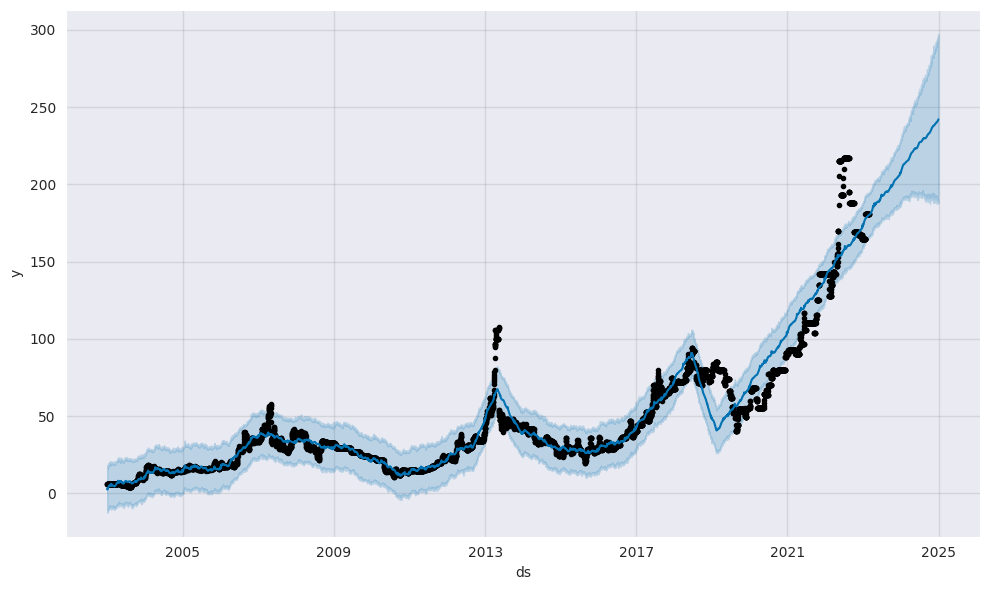

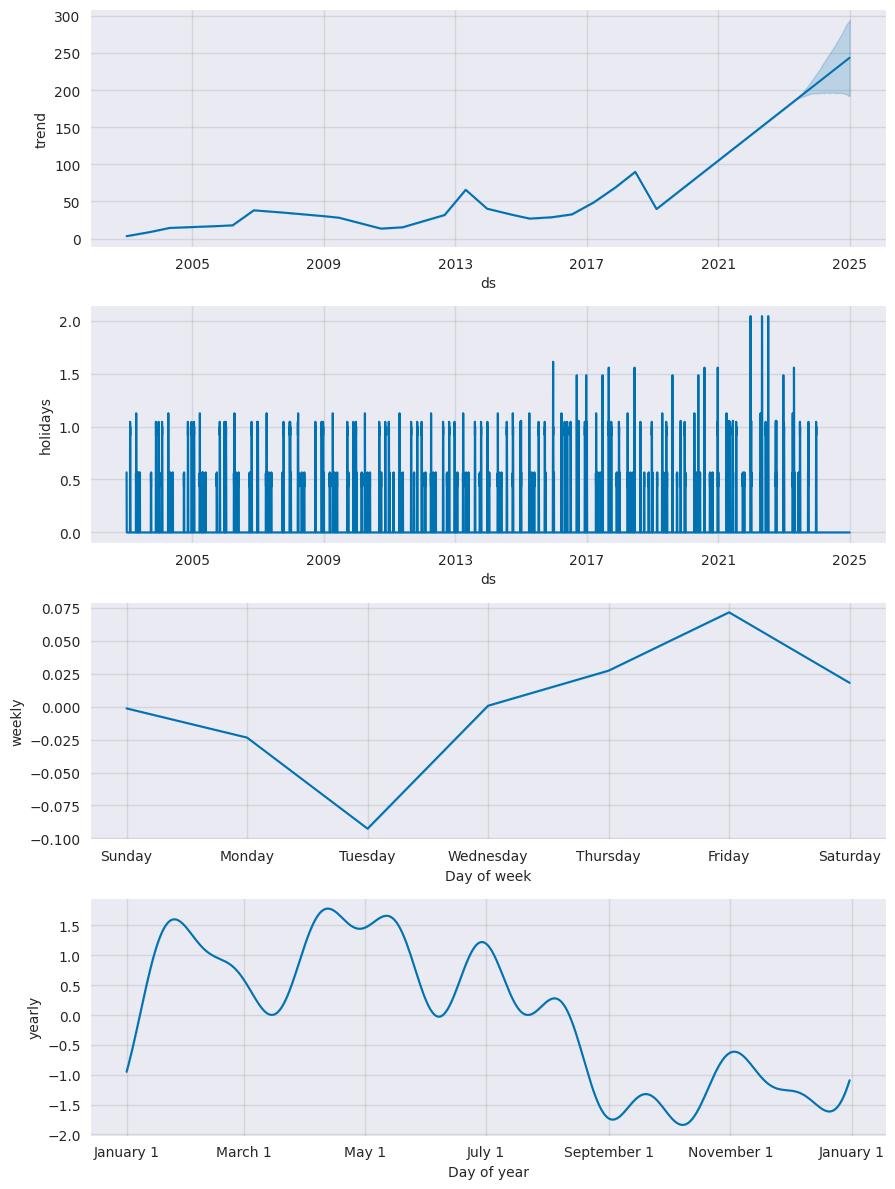

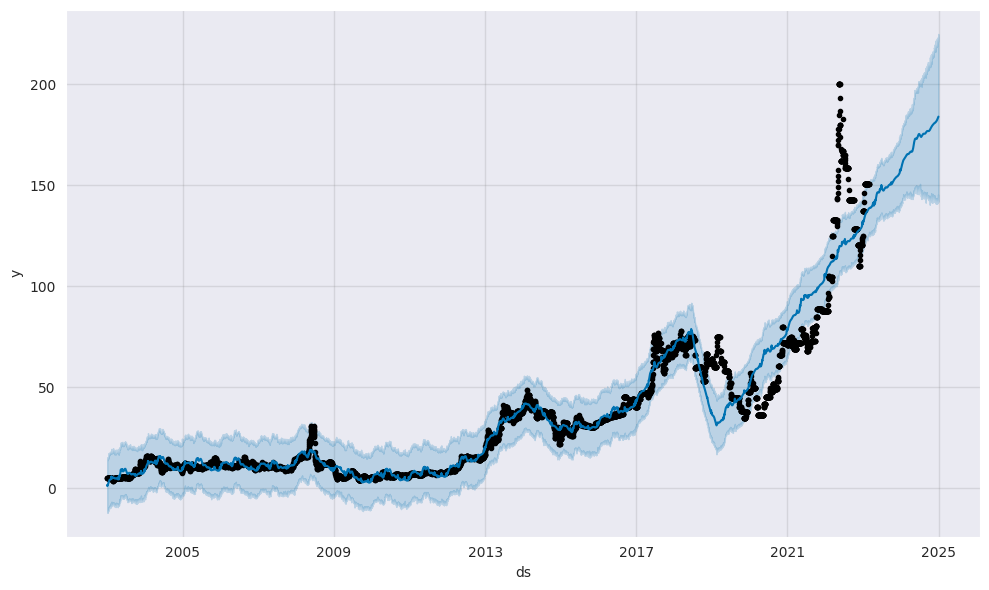

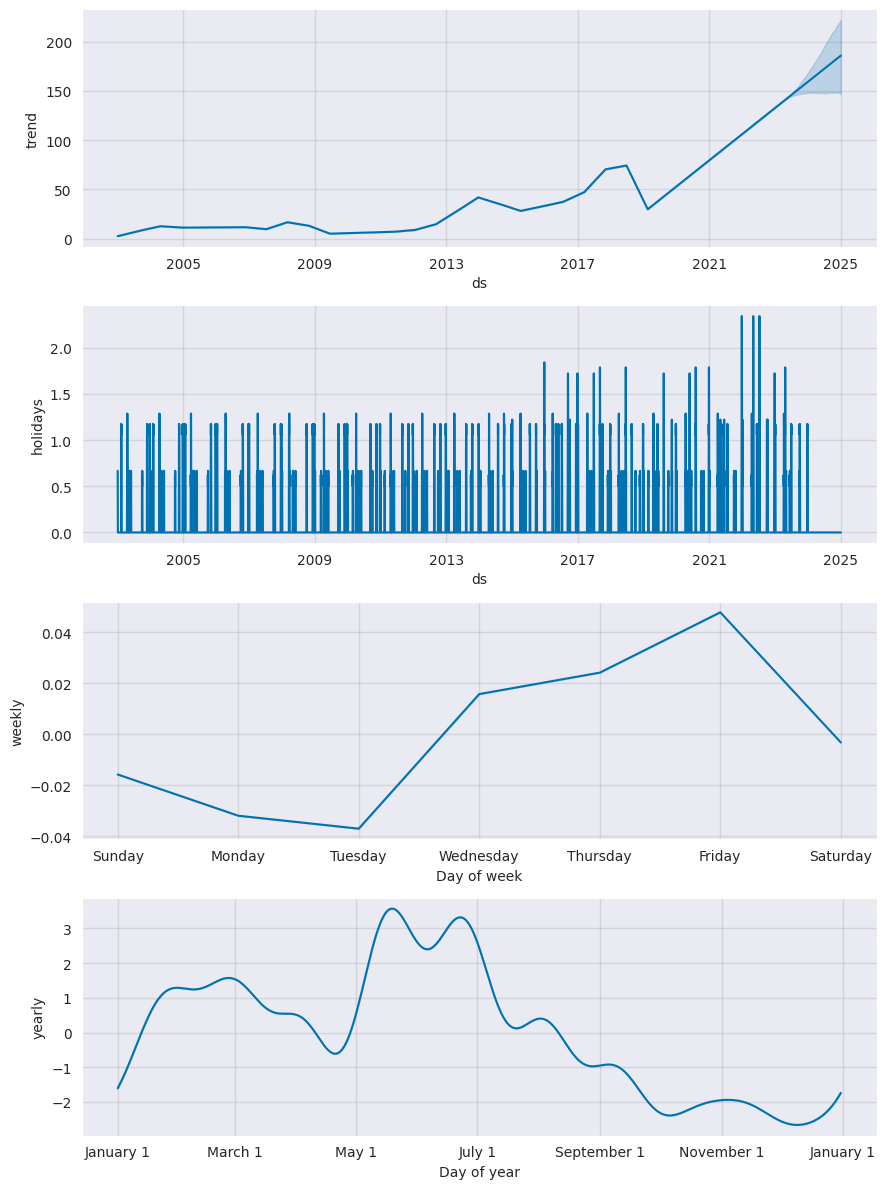

In [ ]:
# using prophet model technique

forecasted_dataframe = []

for feature in financial_tsdata.columns: # plotting for first five: for feature in agriculture_tsdata.columns[:5]:

    # formatting
    financial_tsdata_copy = financial_tsdata[feature].copy().reset_index()
    financial_tsdata_copy.columns = ['ds', 'y']
    financial_tsdata_copy[['y']] = financial_tsdata_copy[['y']].apply(pd.to_numeric)
    financial_tsdata_copy['ds'] = pd.to_datetime(financial_tsdata_copy['ds'])

    financial_tsdata_copy_train = financial_tsdata_copy[financial_tsdata_copy['ds'] < start_date_of_forecast]

    # search and get the rightparam_dicts for the sector
    param_dicts = dicts[feature]

    # model
    m = Prophet(changepoint_prior_scale = dicts[feature]['changepoint_prior_scale'],
                seasonality_prior_scale = dicts[feature]['seasonality_prior_scale'],
                holidays = holiday)

    m.fit(financial_tsdata_copy_train)

    future_df = m.make_future_dataframe(periods = days_of_prediction)
    forecast_prophet_train = m.predict(future_df)

    fig1 = m.plot(forecast_prophet_train)
    fig2 = m.plot_components(forecast_prophet_train)

    forecasted_df = forecast_prophet_train[forecast_prophet_train['ds'] >= start_date_of_forecast]
    forecasted_dataframe.append(forecasted_df)

## forecasting visualization
2023 - March to December
2024 - January to December (leap year)

## Conclusions
<b>`...........................................................................................................`</b>